# IMPORT STATEMENTS

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.style.use("fast")
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances

import random
import statistics

!pip install -q kneed
from kneed import KneeLocator

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
def remove_outliers_iqr(df, threshold=1.5):
    filtered_df = df.copy()  # Copia del DataFrame originale

    for col in df.columns:
        data = df[col]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Rimuovi le righe contenenti outlier
        filtered_df = filtered_df.loc[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_df

def remove_outliers_std(df, threshold=2):
    filtered_df = df.copy()  # Copy of the original DataFrame

    for col in df.columns:
        data = df[col]
        mean = np.mean(data)
        std = np.std(data)

        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        # Remove rows containing outliers
        filtered_df = filtered_df.loc[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_df


name_vars = ['name', 'artists', 'album_name']

continuous_vars = [
    'duration_min', 'popularity', 'danceability',
    'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'n_bars', 'processing'
 ]

categorical_vars = ['key', 'mode', 'explicit', 'genre']

features_list = continuous_vars + categorical_vars

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasetPath = '/content/drive/MyDrive/UNIPI/DM1/DATASET: Spotify/DM1 - Project/files/dm1_df_understanding.csv'
data = pd.read_csv(datasetPath)

data.head(3)

name  explicit  popularity  artists  album_name  danceability    energy  \
0     0         0    0.999431        0           0      0.715310 -0.541799   
1     1         0   -1.475429        1           1     -2.481888 -1.740911   
2     2         0   -1.314025        2           2     -0.968238  0.748097   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
0 -0.080300 -0.605102     1     0.158245     -0.005753          0.650965   
1 -1.196090 -2.648529     0    -0.037820     -0.063412          1.690353   
2 -0.917142  0.241441     0    -0.508373     -0.921953          1.340409   

   liveness   valence     tempo    n_bars  processing     genre  duration_min  
0  0.328795  0.714789  0.598325  0.167839   -0.758998 -1.647509     -0.039437  
1  0.733324 -1.454678 -1.488278  0.354228    0.138354 -1.474087      1.540689  
2  0.231503  0.188115 -0.203212  0.447423    1.237725 -1.300665      0.677386

## Other

In [ ]:
def cluster_separation_list(df, centers):
  average_dists = []
  features = df.columns

  for feature in range(centers.shape[1]):
    dists = [distance.euclidean(np.array([centers[i, feature]]), np.array([centers[j, feature]])) for i in range(len(centers)) for j in range(i+1, len(centers))]
    average_dists.append(sum(dists) / len(dists))

  # Crea un dataframe con le feature e le distanze medie
  features_df = pd.DataFrame({'feature': features[:len(average_dists)], 'average_dist': average_dists})

  # Ordina il dataframe in base alle distanze medie
  features_df = features_df.sort_values(by='average_dist', ascending=False)

  return list(zip(features_df['feature'].tolist(), features_df['average_dist'].tolist()))

def plot_feature_importances(feature_importances, title):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])

    # Sort the DataFrame by importance
    df = df.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(df['Feature'], df['Importance'], color='green')
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def sse_elbow(dataframe, max_clusters):
  # A list holds the SSE values for each k
  sse = []
  for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(dataframe)
    sse.append(kmeans.inertia_)

  # Find the elbow point
  kl = KneeLocator(range(1, max_clusters+1), sse, curve="convex", direction="decreasing")
  elbow_point = kl.elbow

  plt.plot(range(1, max_clusters+1), sse)
  plt.xticks(range(1, max_clusters+1))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")

  # Add a vertical line at the elbow point
  plt.axvline(x=elbow_point, color='r', linestyle='--')

  plt.show()

def sil_k_choice(dataframe, max_clusters):
  sil_list = []
  dist = squareform(pdist(dataframe)) # using a precomputed distance matrix

  for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
    kmeans.fit(dataframe)
    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

  # Find the second highest peak
  sorted_sil_list = sorted([(value, index) for index, value in enumerate(sil_list)], reverse=True)
  second_peak = sorted_sil_list[1][1] if len(sorted_sil_list) > 1 else None

  plt.plot(range(2, max_clusters+1), sil_list)
  plt.xticks(range(2, max_clusters+1))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")

  '''# Add a vertical line at the second highest peak
  if second_peak is not None:
    plt.axvline(x=second_peak+2, color='r', linestyle='--')'''

  plt.show()

def cluster_distances_plot(data, kmeans, title):
  clust_name = [str(i) for i in range(1, kmeans.n_clusters+1)]

  centers = kmeans.cluster_centers_

  data = data.assign(kmeans_labels=kmeans.labels_)

  cluster_sizes = data['kmeans_labels'].value_counts()

  plt.figure(figsize=(22, 5))
  for i in range(len(centers)):
      plt.plot(centers[i], marker='o', label='Cluster '+clust_name[i])
  plt.xticks(range(len(data.columns)), data.columns, fontsize=13)
  plt.legend(fontsize=13, loc='best')
  plt.title(title)
  plt.grid(axis='y')
  plt.show()


def calculate_distances(centers, features):
    for feature in range(centers.shape[1]):
        dists = [distance.euclidean(np.array([centers[i, feature]]), np.array([centers[j, feature]])) for i in range(len(centers)) for j in range(i+1, len(centers))]
        dists = ["{:.2f}".format(dist) for dist in dists]
        print(f'{features[feature]}: {dists}')


def sil_score(kmeans, df):
  clusters = df['kmeans_labels']
  score = silhouette_score(df, clusters)
  return score

def plot_kmeans_selected(data, kmeans, title):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  pairs = [(0, 1), (0, 2), (1, 2)]

  for i, (x, y) in enumerate(pairs):
    axs[i].scatter(data.iloc[:, x], data.iloc[:, y], c=kmeans.labels_)
    axs[i].set_xlabel(data.columns[x])
    axs[i].set_ylabel(data.columns[y])
    axs[i].set_title(title)
  plt.show()

def compute_correlation(X, labels):
    # Compute the distance matrix
    distance_matrix = pairwise_distances(X)

    # Compute the ideal similarity matrix
    ideal_similarity_matrix = np.equal.outer(labels, labels).astype(int)

    # Compute the correlation
    correlation, _ = pearsonr(distance_matrix[np.triu_indices(X.shape[0], k=1)],
                              ideal_similarity_matrix[np.triu_indices(X.shape[0], k=1)])

    return correlation

def clustering_metrics(dataframe, kmeans):
  sse_sil = []
  dist = squareform(pdist(dataframe))

  sse_sil.append(kmeans.inertia_)
  sse_sil.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

  return sse_sil

# CLUSTERING

In [ ]:
df = data.copy(deep=True)

In [ ]:
df.describe().T

count          mean          std       min          25%  \
name              15000.0  7.499500e+03  4330.271354  0.000000  3749.750000   
explicit          15000.0  6.440000e-02     0.245472  0.000000     0.000000   
popularity        15000.0  5.400125e-17     1.000033 -1.475429    -0.722211   
artists           15000.0  1.987648e+03  1755.410934  0.000000   486.000000   
album_name        15000.0  4.084496e+03  2832.826566  0.000000  1569.750000   
danceability      15000.0 -4.140096e-16     1.000033 -2.837132    -0.566658   
energy            15000.0  1.080025e-16     1.000033 -2.482318    -0.666628   
key               15000.0 -7.768601e-17     1.000033 -1.475037    -0.917142   
loudness          15000.0 -9.521273e-17     1.000033 -6.766353    -0.289938   
mode              15000.0  6.284000e-01     0.483248  0.000000     0.000000   
speechiness       15000.0  1.487403e-16     1.000033 -0.966241    -0.536053   
acousticness      15000.0  2.629008e-17     1.000033 -0.922224    -0.892651   
instrumentalness  15000.0  2.652693e-17     1.000033 -0.748814    -0.748814   
liveness          15000.0 -7.958079e-17     1.000033 -1.110102    -0.608792   
valence           15000.0  9.000208e-18     1.000033 -1.575885    -0.868842   
tempo             15000.0 -7.105427e-19     1.000033 -3.855839    -0.725889   
n_bars            15000.0 -1.801226e-16     1.000033 -1.709373    -0.604348   
processing        15000.0 -1.070551e-16     1.000033 -1.197065    -0.848355   
genre             15000.0 -9.473903e-19     1.000033 -1.647509    -0.823754   
duration_min      15000.0  9.900229e-17     1.000033 -1.861254    -0.521975   

                          50%           75%           max  
name              7499.500000  11249.250000  14999.000000  
explicit             0.000000      0.000000      1.000000  
popularity          -0.184198      0.784226      3.581893  
artists           1437.000000   3178.000000   6256.000000  
album_name        3673.000000   6399.000000   9819.000000  
danceability         0.148979      0.741053      2.208366  
energy               0.199607      0.861578      1.300369  
key                 -0.080300      0.756543      1.593386  
loudness             0.265086      0.631744      2.006627  
mode                 1.000000      1.000000      1.000000  
speechiness         -0.378048      0.055599      9.863418  
acousticness        -0.451850      0.816643      2.100309  
instrumentalness    -0.740640      1.194163      1.862714  
liveness            -0.439299      0.323674      3.979803  
valence             -0.075223      0.819403      2.013440  
tempo                0.033557      0.590981      3.050698  
n_bars              -0.151687      0.407483     27.181046  
processing          -0.379961      0.947907      1.540059  
genre                0.000000      0.823754      1.647509  
duration_min        -0.148305      0.328897     30.263747

In [ ]:
# TEST: removing outliers
df_no_outliers = df.copy()

outlier_features = ['danceability', 'loudness', 'speechiness', 'liveness', 'tempo', 'n_bars', 'duration_min']
df_filtered_no_outliers = df_no_outliers[outlier_features]

def remove_outliers_combined_post(df, df_filtered, threshold_iqr=1.5, threshold_std=2):
    filtered_df_iqr = remove_outliers_iqr(df_filtered, threshold_iqr)
    filtered_df_std = remove_outliers_std(df_filtered, threshold_std)

    # Get the intersection of indices from all methods
    common_indices = filtered_df_iqr.index.intersection(filtered_df_std.index)

    # Create a new dataframe with the filtered values
    df_filtered = df_filtered.loc[common_indices]

    # Replace the original dataframe columns with the filtered ones
    for column in df_filtered.columns:
        df[column] = df_filtered[column]

    # Remove rows with NaN values
    df = df.dropna()

    return df

df_no_outliers = remove_outliers_combined_post(df=df_no_outliers, df_filtered=df_filtered_no_outliers)
print(f"Combined:{df_no_outliers.shape}, {(1-df_no_outliers.shape[0]/df.shape[0])*100:.2f}% samples cut")

Combined:(10575, 20), 29.50% samples cut


Il cut è minore perché abbiamo droppato due features con molti outliers (time_signature, features_duration_ms).

In [ ]:
print(df.shape)
print(df_no_outliers.shape)

(15000, 20)
(10575, 20)


In [ ]:
print(df.processing.unique())

[-0.75899773  0.13835399  1.23772541  1.54005944 -1.05860368 -0.84835484
 -0.70600893  0.43399863  0.9479072  -1.18941724 -0.37996082 -1.19706453]


<Axes: xlabel='processing', ylabel='Count'>

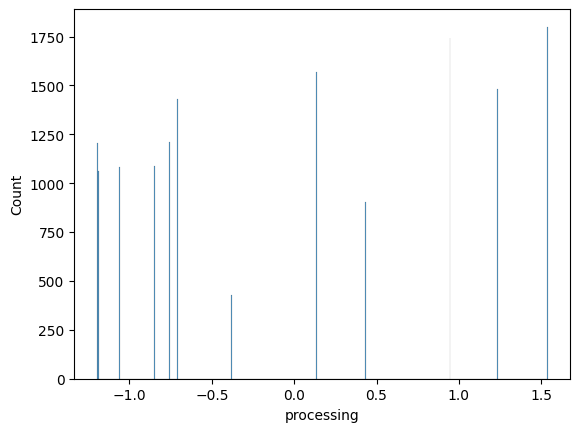

In [ ]:
sns.histplot(data=df, x=df.processing, bins=500)

In [ ]:
features_list.remove('processing')
features_list.remove('key')
features_list.remove('mode')
features_list.remove('explicit')
features_list.remove('genre')

In [ ]:
F = df[features_list]
C = df_no_outliers[features_list]

In [ ]:
print(F.shape)
print(C.shape)

(15000, 12)
(10575, 12)


In [ ]:
print(features_list)
print(len(features_list))

['duration_min', 'popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'n_bars']
12


## Centroid-based: K-Means

#### Choosing k

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

In [ ]:
X.head()

duration_min  popularity  danceability    energy  loudness  speechiness  \
0     -0.039437    0.999431      0.715310 -0.541799 -0.605102     0.158245   
1      1.540689   -1.475429     -2.481888 -1.740911 -2.648529    -0.037820   
2      0.677386   -1.314025     -0.968238  0.748097  0.241441    -0.508373   
3      0.179643   -0.237999     -0.144484 -0.269446  0.547489    -0.083952   
4      0.475378   -0.130396      0.473332  0.116388 -0.407120    -0.344602   

   acousticness  instrumentalness  liveness   valence     tempo    n_bars  
0     -0.005753          0.650965  0.328795  0.714789  0.598325  0.167839  
1     -0.063412          1.690353  0.733324 -1.454678 -1.488278  0.354228  
2     -0.921953          1.340409  0.231503  0.188115 -0.203212  0.447423  
3     -0.720722         -0.745497 -0.510988 -0.187051  0.556327  0.354228  
4     -0.920476         -0.495757  0.420966  0.722004  0.652663  0.727008

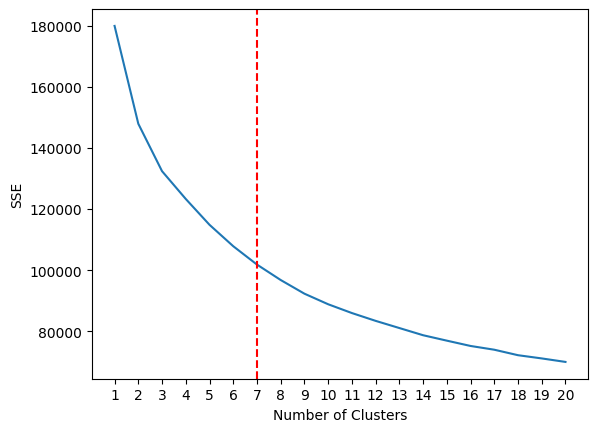

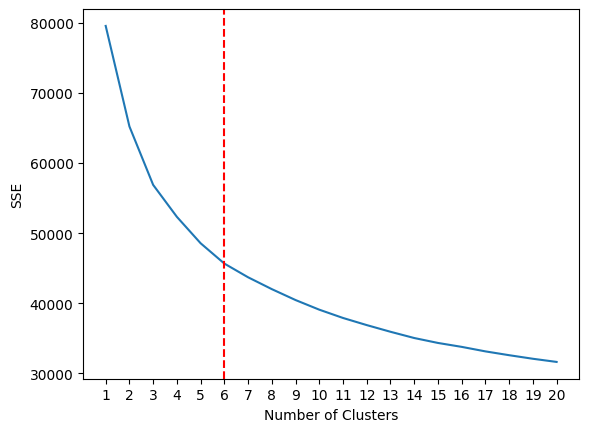

In [ ]:
'''
------------- ELBOW METHOD -------------
To perform the elbow method, run several
k-means, increment k with each iteration
and record the SSE.
----------------------------------------
'''


sse_elbow(X, 20)
sse_elbow(X_outcut, 20)

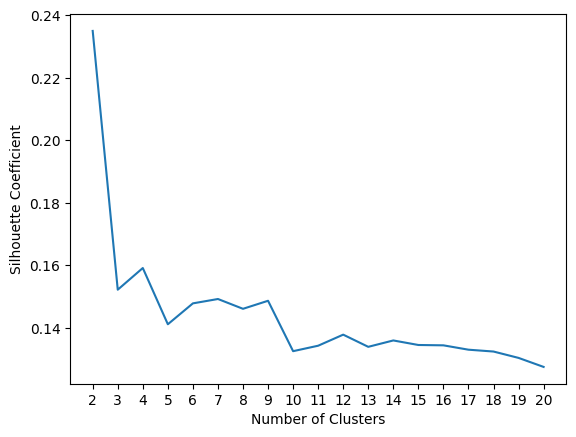

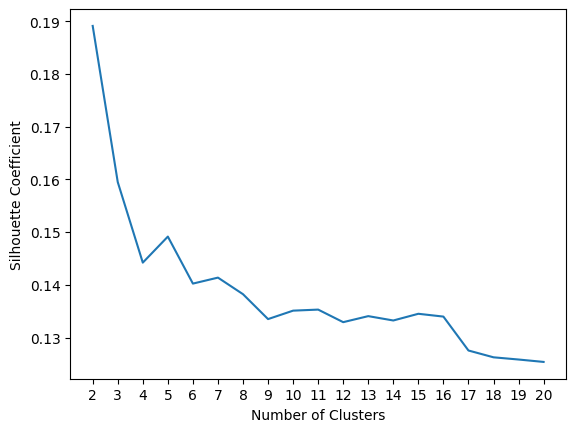

In [ ]:
'''
-------- SILHOUETTE SCORE METHOD -------
The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies
how well a data point fits into its assigned cluster based on two factors:

- How close the data point is to other points in the cluster
- How far away the data point is from points in other clusters Silhouette coefficient values range between -1 and 1.
Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the scikit-learn implementation of the silhouette coefficient, the average silhouette
coefficient of all the samples is summarized into one score. The silhouette score() function
needs a minimum of two clusters, or it will raise an exception.
'''



sil_k_choice(X, 20)
sil_k_choice(X_outcut, 20)

In [ ]:
'''%%time
from scipy.spatial.distance import pdist, squareform
sse_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)

sil_list = []
dist = squareform(pdist(X)) # using a precomputed distance matrix

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

fig, axs = plt.subplots(2)

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots'''

"%%time\nfrom scipy.spatial.distance import pdist, squareform\nsse_list = []\n\nfor k in range(2, 11):\n    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(X)\n    sse_list.append(kmeans.inertia_)\n\nsil_list = []\ndist = squareform(pdist(X)) #\xa0using a precomputed distance matrix\n\nfor k in range(2, 11):\n    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)\n    kmeans.fit(X)\n    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))\n\nfig, axs = plt.subplots(2)\n\nsns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])\naxs[0].set(xlabel='k', ylabel='SSE')\n\nsns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])\naxs[1].set(xlabel='k', ylabel='Silhouette')\n\nplt.tight_layout() # Adjust the padding between and around subplots"

### K-MEANS

#### All features

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X)

# without outliers
kmeans_outcut = KMeans(n_clusters=5, n_init=10, max_iter=100, random_state=42)
kmeans_outcut.fit(X_outcut)

KMeans(max_iter=100, n_clusters=5, n_init=10, random_state=42)

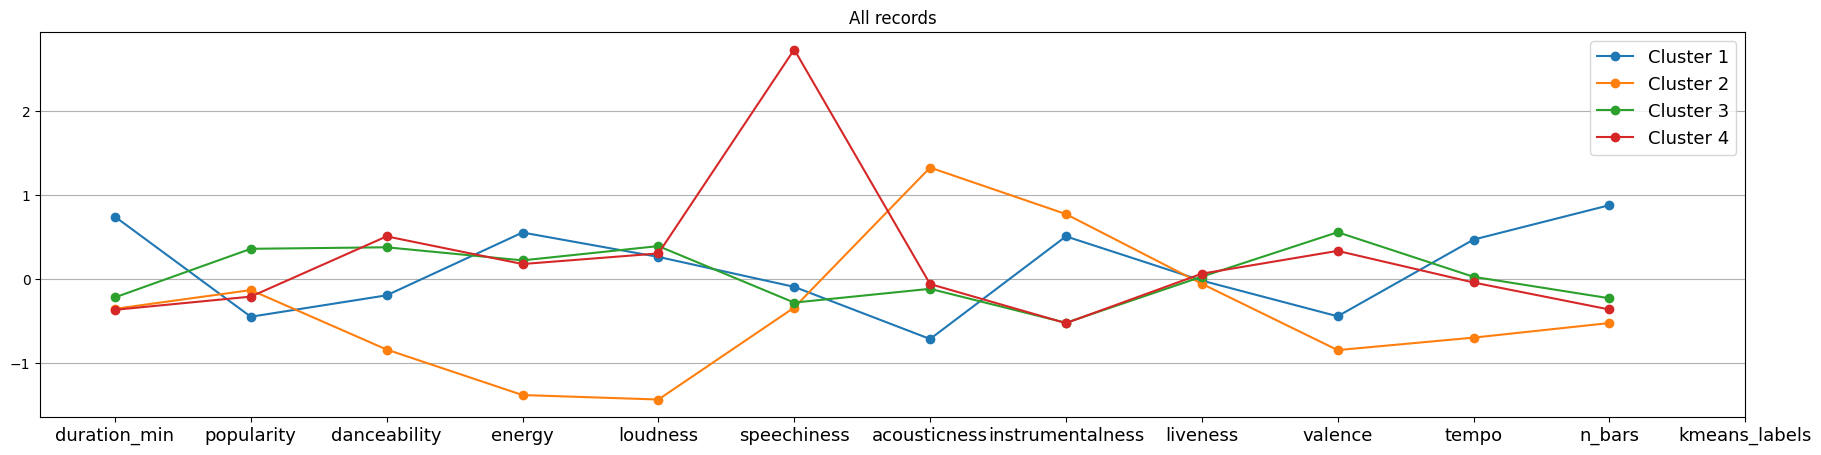

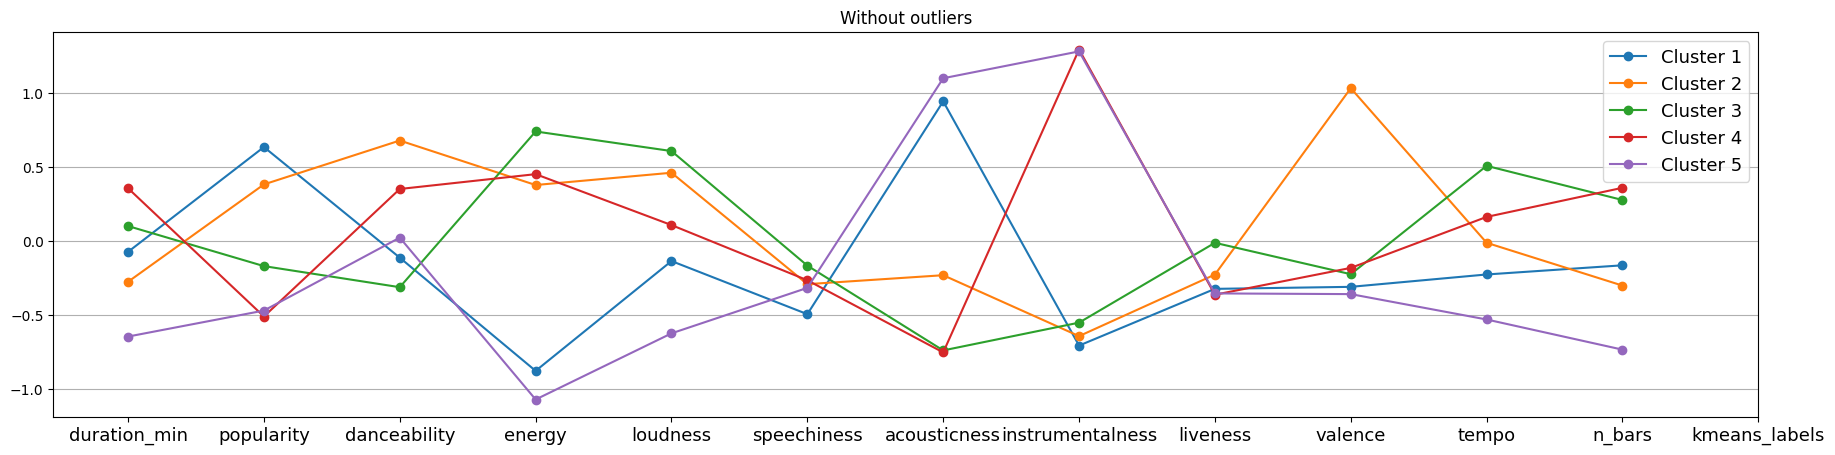

In [ ]:
cluster_distances_plot(data=X, kmeans=kmeans, title="All records")
cluster_distances_plot(data=X_outcut, kmeans=kmeans_outcut, title="Without outliers")

In [ ]:



# Calcola le distanze tra i centroidi per ogni feature nel dataset con outlier
print("Distances for dataset with outliers:")
calculate_distances(kmeans.cluster_centers_, X.columns)

# Calcola le distanze tra i centroidi per ogni feature nel dataset senza outlier
print("\nDistances for dataset without outliers:")
calculate_distances(kmeans_outcut.cluster_centers_, X_outcut.columns)

Distances for dataset with outliers:
duration_min: ['1.10', '0.96', '1.11', '0.14', '0.01', '0.15']
popularity: ['0.32', '0.81', '0.24', '0.49', '0.08', '0.57']
danceability: ['0.65', '0.57', '0.70', '1.22', '1.35', '0.13']
energy: ['1.93', '0.33', '0.38', '1.60', '1.56', '0.04']
loudness: ['1.70', '0.13', '0.04', '1.83', '1.74', '0.09']
speechiness: ['0.25', '0.19', '2.82', '0.06', '3.07', '3.01']
acousticness: ['2.04', '0.60', '0.65', '1.44', '1.39', '0.06']
instrumentalness: ['0.27', '1.03', '1.03', '1.29', '1.30', '0.00']
liveness: ['0.04', '0.05', '0.08', '0.08', '0.12', '0.04']
valence: ['0.40', '1.00', '0.78', '1.40', '1.18', '0.22']
tempo: ['1.17', '0.44', '0.51', '0.72', '0.66', '0.07']
n_bars: ['1.40', '1.11', '1.24', '0.30', '0.16', '0.13']

Distances for dataset without outliers:
duration_min: ['0.20', '0.17', '0.43', '0.57', '0.38', '0.63', '0.37', '0.26', '0.75', '1.00']
popularity: ['0.25', '0.80', '1.15', '1.11', '0.55', '0.89', '0.85', '0.34', '0.30', '0.04']
danceabil

Ci sono tre distanze calcolate: per duration_min (con outliers), ad esempio, la distanza tra il primo e il secondo centroide è 1.18, la distanza tra il primo e il terzo centroide è 0.16, e la distanza tra il secondo e il terzo centroide è 1.34.

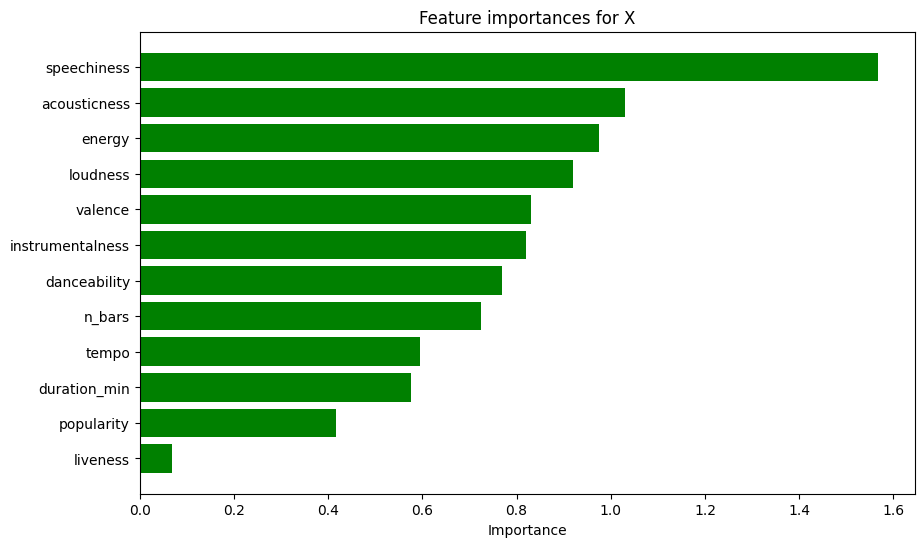

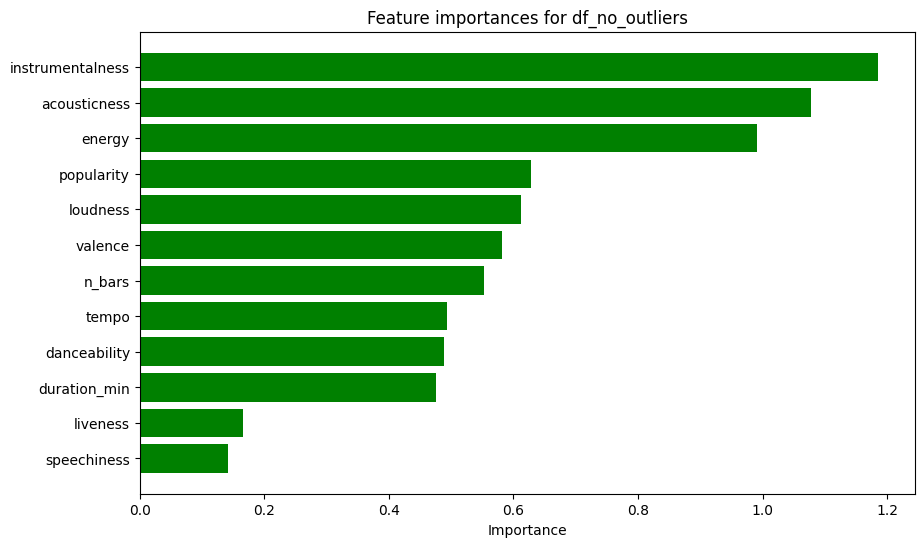

In [ ]:
# Calculate feature importances for X
feature_importances_X = cluster_separation_list(X, kmeans.cluster_centers_)

# Calculate feature importances for df_no_outliers
feature_importances_X_outcut = cluster_separation_list(X_outcut, kmeans_outcut.cluster_centers_)

# Plot feature importances for X
plot_feature_importances(feature_importances_X, title="Feature importances for X")

# Plot feature importances for df_no_outliers
plot_feature_importances(feature_importances_X_outcut, title="Feature importances for df_no_outliers")

In [ ]:
feature_importances_X[0:6]

[('speechiness', 1.5667190618515547),
 ('acousticness', 1.0295919507497018),
 ('energy', 0.9744057282081431),
 ('loudness', 0.9198893653137598),
 ('valence', 0.831233073081687),
 ('instrumentalness', 0.8204469560845294)]

In [ ]:
feature_importances_X_outcut[0:6]

[('instrumentalness', 1.18514208322976),
 ('acousticness', 1.0776952020405306),
 ('energy', 0.990417015982683),
 ('popularity', 0.6286424102332311),
 ('loudness', 0.612084789600112),
 ('valence', 0.5823033424427349)]

In [ ]:
# Calculate the silhouette score for the generated clusters
X = X.assign(kmeans_labels=kmeans.labels_)
X_outcut = X_outcut.assign(kmeans_labels=kmeans_outcut.labels_)


print(sil_score(kmeans, X))
print(sil_score(kmeans_outcut, X_outcut))

0.216988542829432
0.20486211158273085


#### Selected features

Since the application of k-means on all features in the dataset generates problems in the optimal choice of k and poor results (silhouette score is around 0.16), we proceed with the selection of some features. For each dataset, we choose the top 3 features according to the importance computed above.

In [ ]:
X = X[[x[0] for x in feature_importances_X[0:3]]]
X_outcut = X_outcut[[x[0] for x in feature_importances_X_outcut[0:3]]]

print(X.head(3))
print(X_outcut.head(3))

   speechiness  acousticness    energy
0     0.158245     -0.005753 -0.541799
1    -0.037820     -0.063412 -1.740911
2    -0.508373     -0.921953  0.748097
   instrumentalness  acousticness    energy
0          0.650965     -0.005753 -0.541799
2          1.340409     -0.921953  0.748097
3         -0.745497     -0.720722 -0.269446


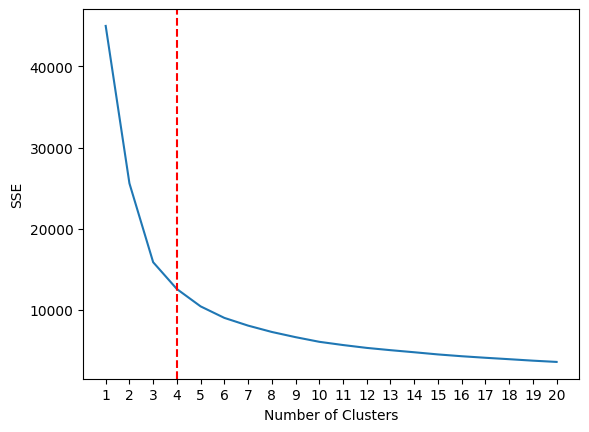

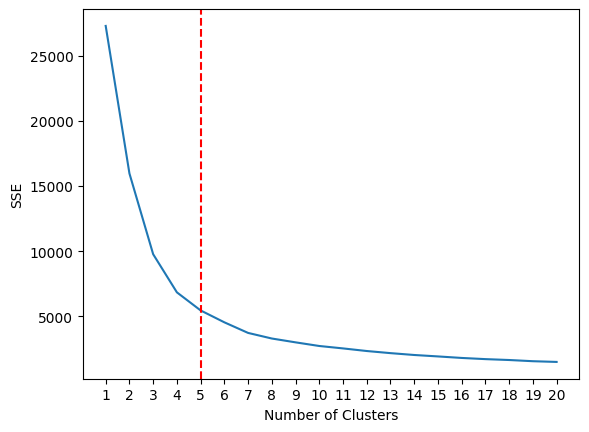

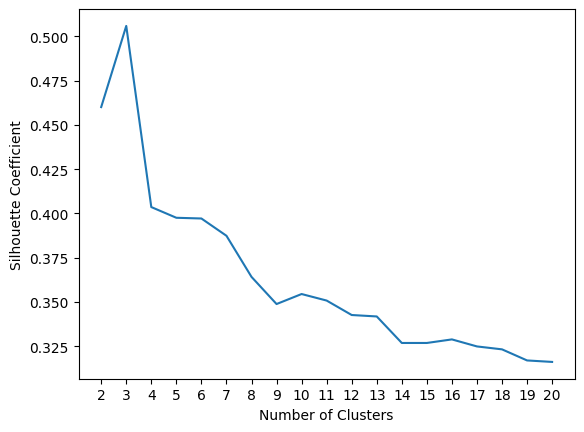

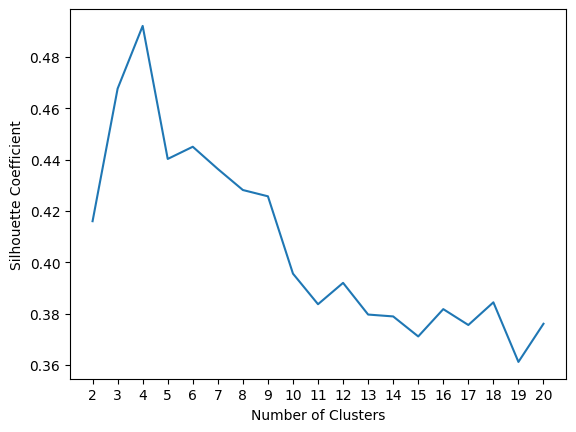

CPU times: user 2min 44s, sys: 48.7 s, total: 3min 33s
Wall time: 2min 35s


In [ ]:
%%time

sse_elbow(X, 20)
sse_elbow(X_outcut, 20)

sil_k_choice(X, 20)
sil_k_choice(X_outcut, 20)

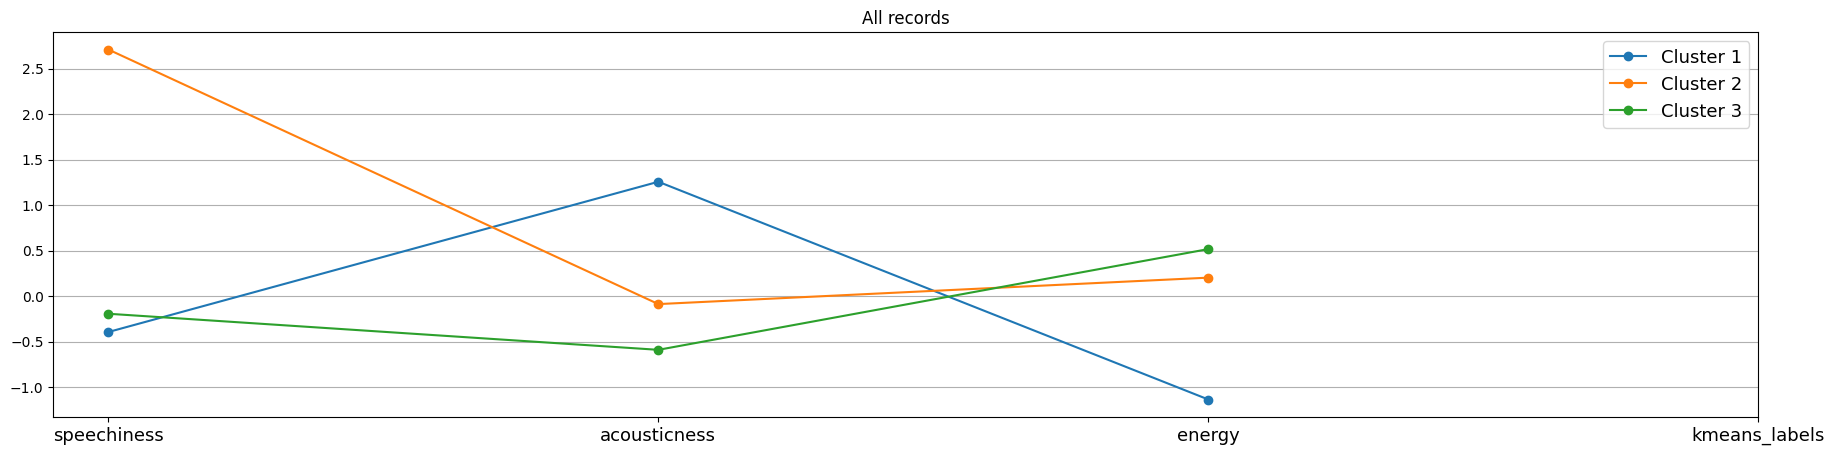

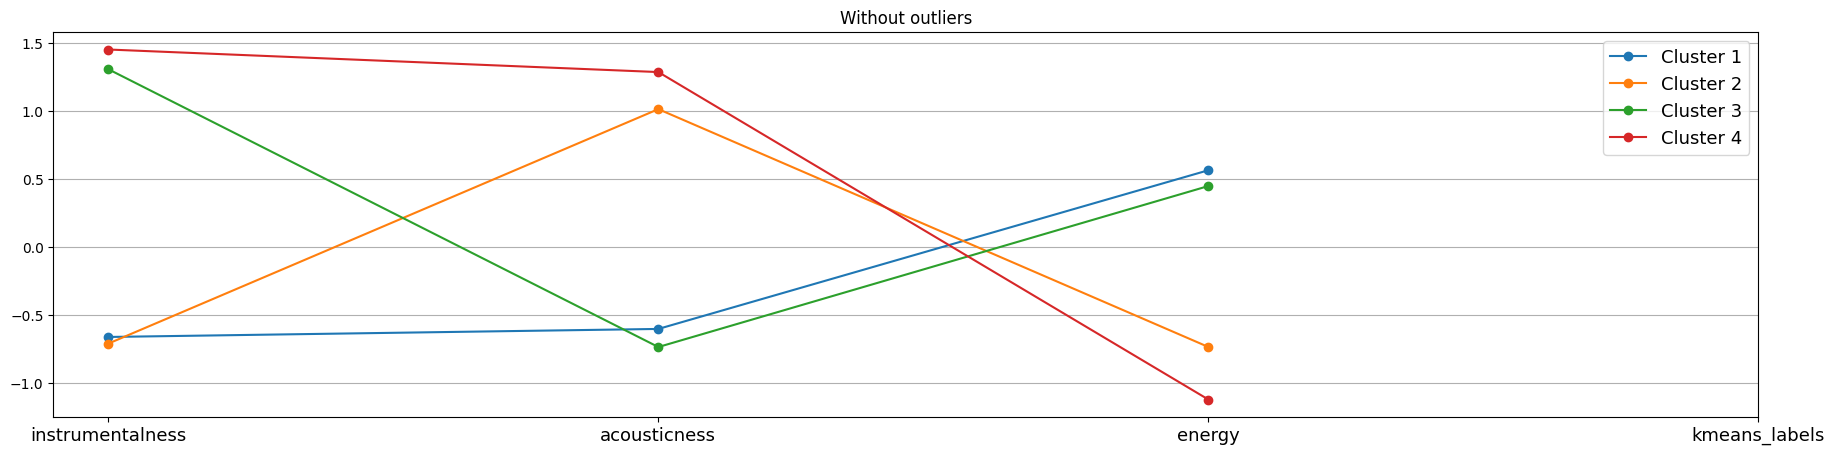

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X)

# without outliers
kmeans_outcut = KMeans(n_clusters=4, n_init=10, max_iter=100, random_state=42)
kmeans_outcut.fit(X_outcut)

cluster_distances_plot(data=X, kmeans=kmeans, title="All records")
cluster_distances_plot(data=X_outcut, kmeans=kmeans_outcut, title="Without outliers")

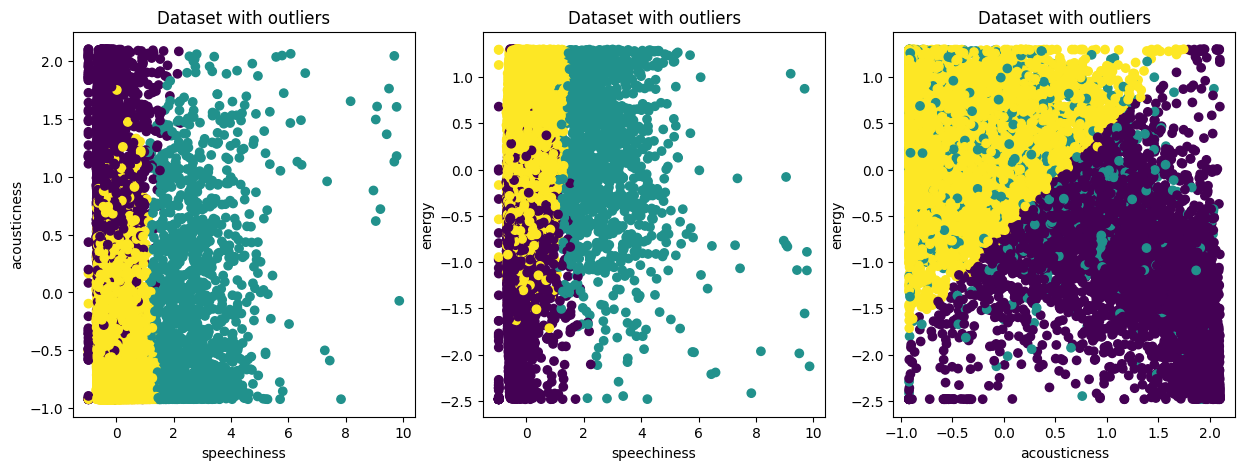

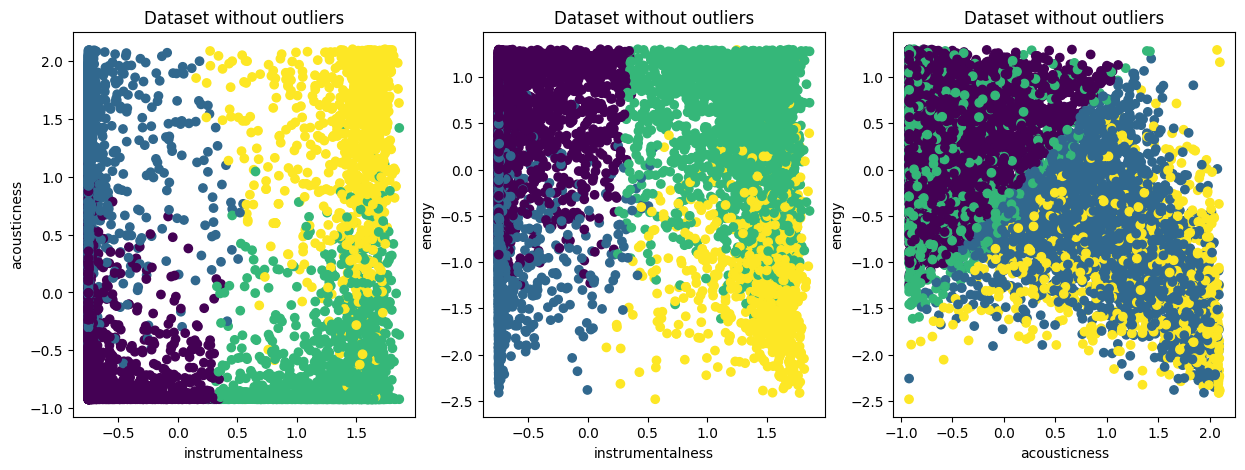

In [ ]:
plot_kmeans_selected(X, kmeans, title="Dataset with outliers")
plot_kmeans_selected(X_outcut, kmeans_outcut, title="Dataset without outliers")

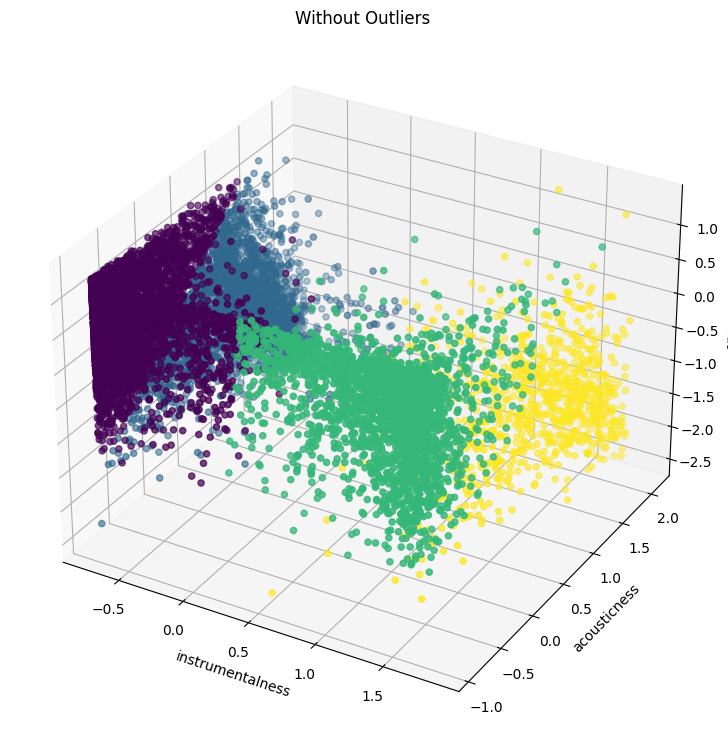

In [ ]:
fig = plt.figure(figsize=(20,20))

'''# Plot for dataset with outliers
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[feature_importances_X[0][0]],
           X[feature_importances_X[1][0]],
           X[feature_importances_X[2][0]],
           c=kmeans.labels_)
ax.set_title('With Outliers')
ax.set_xlabel(feature_importances_X[0][0])
ax.set_ylabel(feature_importances_X[1][0])
ax.set_zlabel(feature_importances_X[2][0])'''

# Plot for dataset without outliers
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X_outcut[feature_importances_X_outcut[0][0]],
           X_outcut[feature_importances_X_outcut[1][0]],
           X_outcut[feature_importances_X_outcut[2][0]],
           c=kmeans_outcut.labels_)
ax.set_title('Without Outliers')
ax.set_xlabel(feature_importances_X_outcut[0][0])
ax.set_ylabel(feature_importances_X_outcut[1][0])
ax.set_zlabel(feature_importances_X_outcut[2][0])

plt.show()

In [ ]:
import plotly.graph_objects as go

# Creazione del grafico per il dataset con outlier
trace1 = go.Scatter3d(
    x=X[feature_importances_X[0][0]],
    y=X[feature_importances_X[1][0]],
    z=X[feature_importances_X[2][0]],
    mode='markers',
    marker=dict(
        color=kmeans.labels_,
        size=4,
        opacity=0.8
    )
)

layout1 = go.Layout(
    title='Con Outlier',
    scene=dict(
        xaxis=dict(title=feature_importances_X[0][0]),
        yaxis=dict(title=feature_importances_X[1][0]),
        zaxis=dict(title=feature_importances_X[2][0]),
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig1 = go.Figure(data=[trace1], layout=layout1)
fig1.show()

# Creazione del grafico per il dataset senza outlier
trace2 = go.Scatter3d(
    x=X_outcut[feature_importances_X_outcut[0][0]],
    y=X_outcut[feature_importances_X_outcut[1][0]],
    z=X_outcut[feature_importances_X_outcut[2][0]],
    mode='markers',
    marker=dict(
        color=kmeans_outcut.labels_,
        size=4,
        opacity=0.8
    )
)

layout2 = go.Layout(
    title='Senza Outlier',
    scene=dict(
        xaxis=dict(title=feature_importances_X_outcut[0][0]),
        yaxis=dict(title=feature_importances_X_outcut[1][0]),
        zaxis=dict(title=feature_importances_X_outcut[2][0]),
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig2 = go.Figure(data=[trace2], layout=layout2)
fig2.show()

ValueError: ignored

In [ ]:
labels = kmeans.labels_
counts = np.bincount(labels)
print("Number of samples (kmeans):", counts)

labels_outcut = kmeans_outcut.labels_
counts_outcut = np.bincount(labels_outcut)
print("Number of samples (kmeans_outcut):", counts_outcut)

Number of samples (kmeans): [4439 1307 9254]
Number of samples (kmeans_outcut): [4896 2602 2190  887]


<ipython-input-56-cdc77b1271b4>:22: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



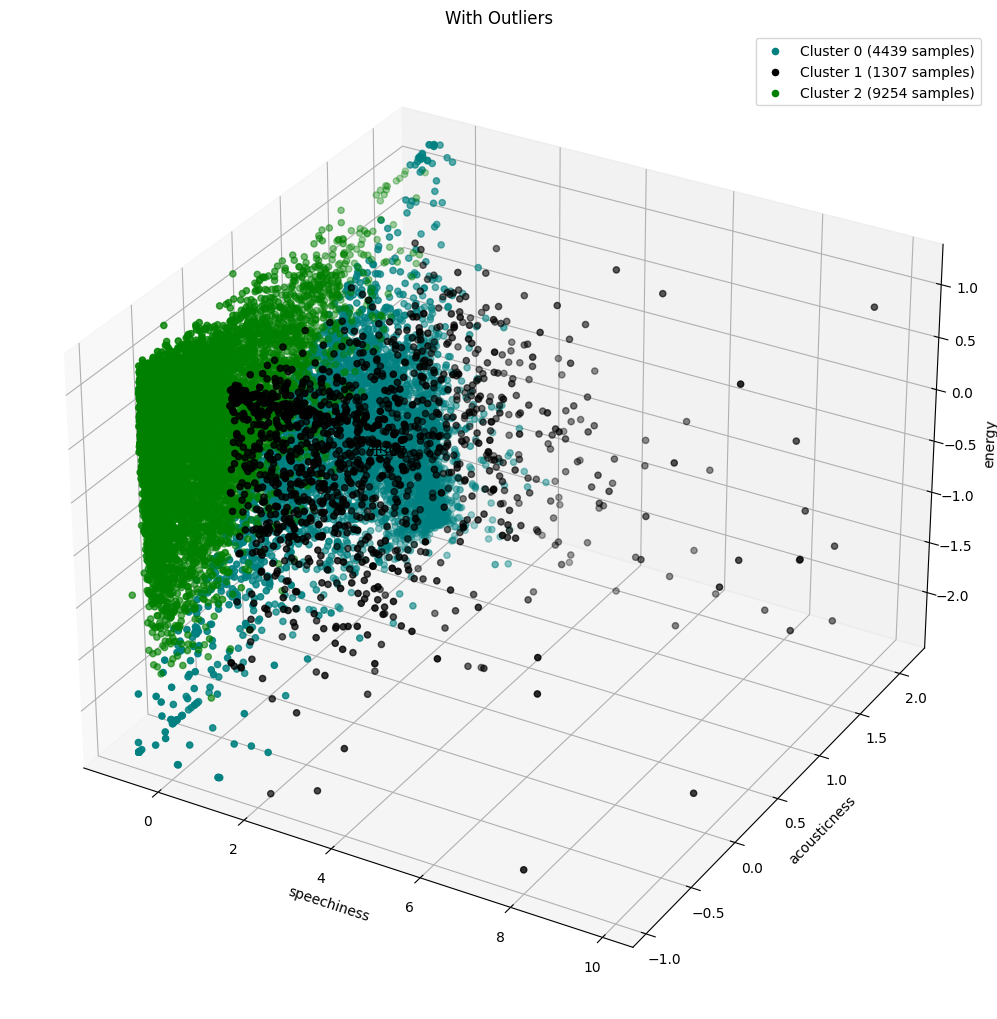

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Creazione di una mappa di colori personalizzata
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['teal', 'black', 'green'])

# Calcolo dei centroidi per kmeans
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(20,20))

# Plot for dataset with outliers
ax = fig.add_subplot(121, projection='3d')

# Creazione di un elenco di colori unici basato sulle etichette kmeans
colors = cmap(np.linspace(0, 1, len(set(kmeans.labels_))))

# Creazione di un elenco di legende vuoto
legends = []

for i, color in zip(range(len(centroids)), colors):
    # Creazione di un grafico 3D con colori specifici per ogni cluster
    ax.scatter(X[feature_importances_X[0][0]][kmeans.labels_==i],
               X[feature_importances_X[1][0]][kmeans.labels_==i],
               X[feature_importances_X[2][0]][kmeans.labels_==i],
               c=color)

    # Aggiunta delle dimensioni dei cluster
    ax.text(centroids[i, 0], centroids[i, 1], centroids[i, 2], str(counts[i]))

    # Aggiunta di legende per ogni cluster
    legends.append('Cluster {} ({} samples)'.format(i, counts[i]))

# Aggiunta dei centroidi come stelle rosse
#ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='*', s=300)

ax.set_title('With Outliers')
ax.set_xlabel(feature_importances_X[0][0])
ax.set_ylabel(feature_importances_X[1][0])
ax.set_zlabel(feature_importances_X[2][0])

# Regolazione dei limiti dell'asse z
ax.set_zlim([min(X[feature_importances_X[2][0]]), max(X[feature_importances_X[2][0]])])

# Aggiunta della legenda al grafico
ax.legend(legends)

plt.tight_layout()
plt.show()

#### Evaluation

The more "atypical" a clustering result is, the more likely it represents valid structure in the data. We must compare the value of an index obtained from the given data with those resulting from random data: if the value of the index is unlikely, then the clusters results are valid.

In [ ]:
# Calculate silhouette score for the dataset with outliers
score_X = silhouette_score(X, kmeans.labels_)

# Calculate silhouette score for the dataset without outliers
score_X_outcut = silhouette_score(X_outcut, kmeans_outcut.labels_)

print(f'Silhouette score for X: {score_X}')
print(f'Silhouette score for X_outcut: {score_X_outcut}')

Silhouette score for X: 0.5058605670537454
Silhouette score for X_outcut: 0.49203791454447027


In [ ]:
# Compute the correlations
correlation = compute_correlation(X, kmeans.labels_)
correlation_outcut = compute_correlation(X_outcut, kmeans_outcut.labels_)

print(f"Correlation for dataset with outliers: {correlation}")
print(f"Correlation for dataset without outliers: {correlation_outcut}")

Correlation for dataset with outliers: -0.7037981781616953
Correlation for dataset without outliers: -0.7227695047559075


The p-value computed at the end represents the probability that a correlation as extreme as the one you found in your original data could be found in a random dataset of the same kind. A smaller p-value indicates that your result is less likely to have occurred by chance, suggesting that the clustering you found is meaningful.

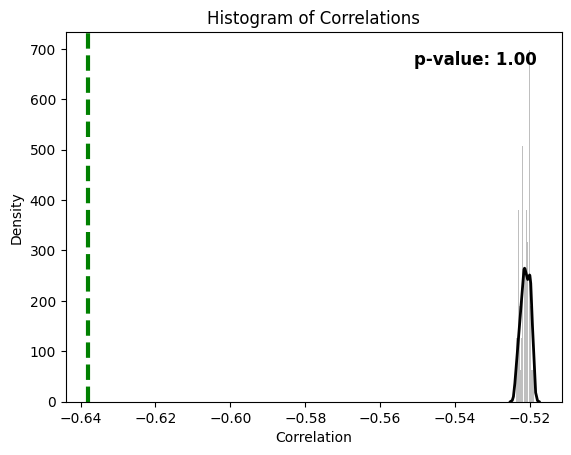

X p-value: 1.0


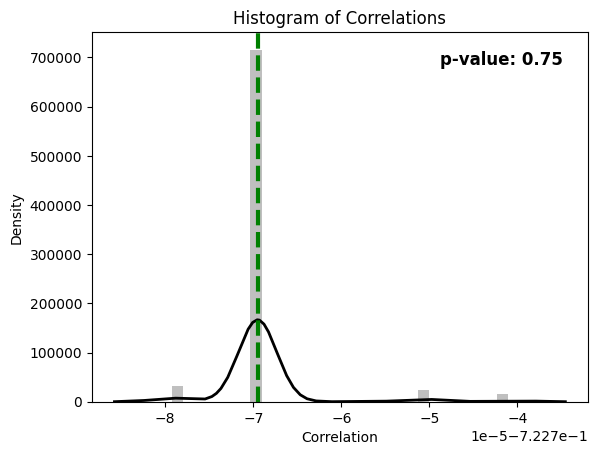

X_outcut p-value: 0.75
CPU times: user 26min 45s, sys: 12min 35s, total: 39min 21s
Wall time: 36min 14s


In [ ]:
'''%%time

def kmeans_evaluation(df, n_permutations, n_clusters, original_corr):
  # Initialize a list to store the correlations for the randomized datasets
  random_corrs = []

  for _ in range(n_permutations):
     # Randomize the data
     df_random = np.random.permutation(df)

     # Compute the clustering for the randomized data
     kmeans = KMeans(n_clusters=n_clusters, n_init=10)
     labels_random = kmeans.fit_predict(df_random)

     # Compute the correlation for the randomized data
     random_corr = compute_correlation(df_random, labels_random)

     # Store the correlation
     random_corrs.append(random_corr)

  # Convert the list of correlations to a numpy array
  random_corrs = np.array(random_corrs)

  # Compute the p-value
  p_value = np.sum(random_corrs >= original_corr) / n_permutations

  # Plot histogram of correlations
  plt.hist(random_corrs, bins=30, alpha=0.5, color='grey', density=True)

  # Plot the KDE
  sns.kdeplot(random_corrs, color='k', linewidth=2)

  plt.axvline(x=original_corr, color='g', linestyle='dashed', linewidth=3)
  plt.title('Histogram of Correlations')
  plt.xlabel('Correlation')
  plt.ylabel('Density')

  # Add p-value text
  plt.text(0.95, 0.95, f'p-value: {p_value:.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.show()

  return p_value

print(f"X p-value: {kmeans_evaluation(X, 100, 6, correlation)}")
print(f"X_outcut p-value: {kmeans_evaluation(X_outcut, 100, 4, correlation_outcut)}")'''

1. Permutation Test: The code is performing a permutation test, which is a type of statistical significance test. In a permutation test, the data is randomly rearranged (permuted) many times, and for each arrangement, the test statistic is calculated. The p-value is then calculated as the proportion of permuted datasets where the test statistic is more extreme than the original test statistic.

2. K-Means Clustering: The code is using K-Means clustering, a popular unsupervised machine learning algorithm, to partition the input data (df) into n_clusters clusters. The algorithm assigns each data point to the cluster whose center (also known as centroid) is nearest. The center is the average of all the points in the cluster — that is, its coordinates are the arithmetic mean for each dimension separately over all the points in the cluster.

3. Correlation Calculation: For each permuted dataset, the code computes the correlation between the dataset and the labels generated by K-Means clustering. This correlation is then compared with the correlation of the original (non-permuted) dataset (original_corr).

4. P-Value Calculation: The p-value is calculated as the proportion of permuted datasets where the correlation is greater than or equal to the correlation of the original dataset. This is done with the line p_value = np.sum(random_corrs >= original_corr) / n_permutations.

The function kmeans_evaluation is then called with different datasets (X and X_outcut), and the p-values for these datasets are printed. If the p-value is small (typically, less than 0.05), it suggests that it is unlikely that we would observe such an extreme correlation under the null hypothesis of no association between the dataset and the labels. This would lead us to reject the null hypothesis and conclude that there is a statistically significant association between the dataset and the labels.

A p-value of 1 would suggest that the cluster assignments in your original data do not significantly deviate from random cluster assignments. This might indicate that the apparent structure in your data (as captured by the K-means clustering) could be due to random chance rather than reflecting any true underlying structure.

The term “null hypothesis” is a key concept in statistical hypothesis testing. It refers to a general statement or default position that there is no relationship between two measured phenomena, or no association among groups.

The term “null” in this context means “none” or “nothing”. So, the null hypothesis assumes that any kind of difference or significance you see in a set of data is due to chance.

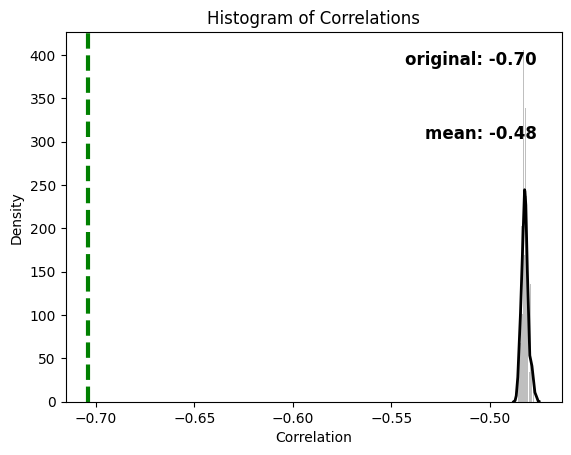

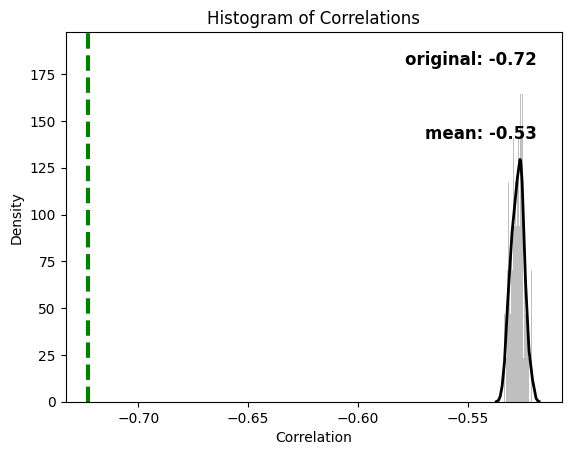

CPU times: user 24min 8s, sys: 9min 44s, total: 33min 52s
Wall time: 31min 2s


In [ ]:
%%time

'''def kmeans_evaluation(df, n_permutations, n_clusters, original_corr):
  # Initialize a list to store the correlations for the randomized datasets
  random_corrs = []

  for _ in range(n_permutations):
    Xi = np.zeros(shape=df.shape)

    for cidx in range(Xi.shape[1]):
        col = df.iloc[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=73)
    kmeans.fit(Xi)

    random_corr = compute_correlation(Xi, kmeans.labels_)
    random_corrs.append(random_corr)

  # Convert the list of correlations to a numpy array
  random_corrs = np.array(random_corrs)

  # Compute the p-value
  p_value = np.sum(random_corrs >= original_corr) / n_permutations

  # Plot histogram of correlations
  plt.hist(random_corrs, bins=30, alpha=0.5, color='grey', density=True)

  # Plot the KDE
  sns.kdeplot(random_corrs, color='k', linewidth=2)

  plt.axvline(x=original_corr, color='g', linestyle='dashed', linewidth=3)
  plt.title('Histogram of Correlations')
  plt.xlabel('Correlation')
  plt.ylabel('Density')

  # Add p-value text
  plt.text(0.95, 0.95, f'p-value: {p_value:.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.show()

  return p_value'''

def kmeans_evaluation(df, n_permutations, n_clusters, original_corr):
  # Initialize a list to store the correlations for the randomized datasets
  random_corrs = []

  for _ in range(n_permutations):
    Xi = np.zeros(shape=df.shape)

    for cidx in range(Xi.shape[1]):
        col = df.iloc[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=73)
    kmeans.fit(Xi)

    random_corr = compute_correlation(Xi, kmeans.labels_)
    random_corrs.append(random_corr)

  # Convert the list of correlations to a numpy array
  random_corrs = np.array(random_corrs)

  # Plot histogram of correlations
  plt.hist(random_corrs, bins=30, alpha=0.5, color='grey', density=True)

  # Plot the KDE
  sns.kdeplot(random_corrs, color='k', linewidth=2)

  plt.axvline(x=original_corr, color='g', linestyle='dashed', linewidth=3)
  plt.title('Histogram of Correlations')
  plt.xlabel('Correlation')
  plt.ylabel('Density')

  plt.text(0.95, 0.95, f'original: {original_corr:.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.text(0.95, 0.75, f'mean: {np.mean(random_corrs):.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.show()


kmeans_evaluation(X, 100, 6, correlation)
kmeans_evaluation(X_outcut, 100, 4, correlation_outcut)

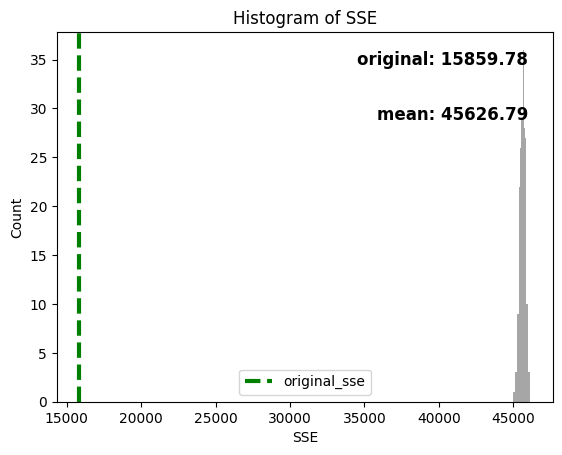

CPU times: user 2min 21s, sys: 58 s, total: 3min 19s
Wall time: 2min 23s


In [ ]:
%%time

N = 200
X_sse = kmeans.inertia_
X_outcut_sse = kmeans_outcut.inertia_

def perm_evaluation(df, N, original_sse, n_clusters):
  sse_stats = []

  for _ in range(N):
    Xi = np.zeros(shape=df.shape)

    for cidx in range(Xi.shape[1]):
        col = df.iloc[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=73)
    kmeans.fit(Xi)
    sse_stats.append(kmeans.inertia_)

  plt.hist(sse_stats, bins='auto', color='grey', alpha=0.7)
  plt.axvline(x=original_sse, color='g', linestyle='dashed', linewidth=3, label = 'original_sse')

  plt.text(0.95, 0.95, f'original: {original_sse:.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.text(0.95, 0.8, f'mean: {np.mean(sse_stats):.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')

  plt.xlabel('SSE')
  plt.ylabel('Count')
  plt.title('Histogram of SSE')
  plt.legend()
  plt.show()

perm_evaluation(df=X, N=N, original_sse=X_sse, n_clusters=3)

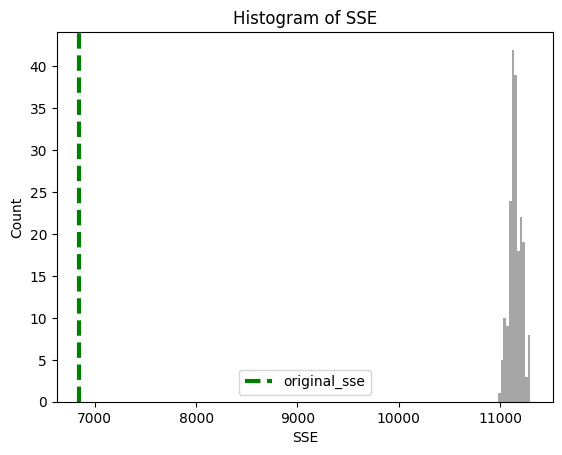

In [ ]:
perm_evaluation(X_outcut, N, X_outcut_sse, 4)

In [ ]:
print("X SSE:", X_sse)
print("X_outcut SSE:", X_outcut_sse)

X SSE: 15859.782353324028
X_outcut SSE: 6848.6544866562635


In [ ]:
X.describe().T

count          mean       std       min       25%       50%  \
speechiness   15000.0  1.487403e-16  1.000033 -0.966241 -0.536053 -0.378048   
acousticness  15000.0  2.629008e-17  1.000033 -0.922224 -0.892651 -0.451850   
energy        15000.0  1.080025e-16  1.000033 -2.482318 -0.666628  0.199607   

                   75%       max  
speechiness   0.055599  9.863418  
acousticness  0.816643  2.100309  
energy        0.861578  1.300369

In [ ]:
X_outcut.head()

instrumentalness  acousticness    energy
0          0.650965     -0.005753 -0.541799
2          1.340409     -0.921953  0.748097
3         -0.745497     -0.720722 -0.269446
4         -0.495757     -0.920476  0.116388
5         -0.748752     -0.917611  1.194454

### Bisecting K-means

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

X.head()

duration_min  popularity  danceability    energy  loudness  speechiness  \
0     -0.039437    0.999431      0.715310 -0.541799 -0.605102     0.158245   
1      1.540689   -1.475429     -2.481888 -1.740911 -2.648529    -0.037820   
2      0.677386   -1.314025     -0.968238  0.748097  0.241441    -0.508373   
3      0.179643   -0.237999     -0.144484 -0.269446  0.547489    -0.083952   
4      0.475378   -0.130396      0.473332  0.116388 -0.407120    -0.344602   

   acousticness  instrumentalness  liveness   valence     tempo    n_bars  
0     -0.005753          0.650965  0.328795  0.714789  0.598325  0.167839  
1     -0.063412          1.690353  0.733324 -1.454678 -1.488278  0.354228  
2     -0.921953          1.340409  0.231503  0.188115 -0.203212  0.447423  
3     -0.720722         -0.745497 -0.510988 -0.187051  0.556327  0.354228  
4     -0.920476         -0.495757  0.420966  0.722004  0.652663  0.727008

In [ ]:
from sklearn.cluster import BisectingKMeans

bkmeans = BisectingKMeans(n_clusters=3, n_init=10, max_iter=100, random_state=42)
bkmeans.fit(X)

bkmeans_outcut = BisectingKMeans(n_clusters=4, n_init=10, max_iter=100, random_state=42)
bkmeans_outcut.fit(X_outcut)

BisectingKMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)

In [ ]:
print(f"SSE X: {clustering_metrics(X, bkmeans)[0]:.2f}")
print(f"SIL X: {clustering_metrics(X, bkmeans)[1]:.2f}")
print('--------------------------------')
print(f"SSE X_outcut: {clustering_metrics(X_outcut, bkmeans_outcut)[0]:.2f}")
print(f"SIL X_outcut: {clustering_metrics(X_outcut, bkmeans_outcut)[1]:.2f}")

SSE X: 133248.97
SIL X: 0.14
--------------------------------
SSE X_outcut: 53130.08
SIL X_outcut: 0.15


In [ ]:
# Calculate feature importances for X
feature_importances_X = cluster_separation_list(X, bkmeans.cluster_centers_)
# Calculate feature importances for df_no_outliers
feature_importances_X_outcut = cluster_separation_list(X_outcut, bkmeans_outcut.cluster_centers_)

for i in range(X.shape[1], 2, -1):

    X_i = X[[x[0] for x in feature_importances_X[0:i]]]
    X_outcut_i = X_outcut[[x[0] for x in feature_importances_X_outcut[0:i]]]

    print(f"------------- {i} features -------------")
    print(f"SSE X{i}: {clustering_metrics(X_i, bkmeans)[0]:.2f}")
    print(f"SIL X{i}: {clustering_metrics(X_i, bkmeans)[1]:.2f}")
    print('-----------------------------------------')
    print(f"SSE X_outcut{i}: {clustering_metrics(X_outcut_i, bkmeans_outcut)[0]:.2f}")
    print(f"SIL X_outcut{i}: {clustering_metrics(X_outcut_i, bkmeans_outcut)[1]:.2f}")
    print('-----------------------------------------')

------------- 12 features -------------
SSE X12: 133248.97
SIL X12: 0.14
-----------------------------------------
SSE X_outcut12: 53130.08
SIL X_outcut12: 0.15
-----------------------------------------
------------- 11 features -------------
SSE X11: 133248.97
SIL X11: 0.16
-----------------------------------------
SSE X_outcut11: 53130.08
SIL X_outcut11: 0.16
-----------------------------------------
------------- 10 features -------------
SSE X10: 133248.97
SIL X10: 0.17
-----------------------------------------
SSE X_outcut10: 53130.08
SIL X_outcut10: 0.16
-----------------------------------------
------------- 9 features -------------
SSE X9: 133248.97
SIL X9: 0.19
-----------------------------------------
SSE X_outcut9: 53130.08
SIL X_outcut9: 0.17
-----------------------------------------
------------- 8 features -------------
SSE X8: 133248.97
SIL X8: 0.18
-----------------------------------------
SSE X_outcut8: 53130.08
SIL X_outcut8: 0.18
-------------------------------------

In [ ]:
# 4 features (based on score above)
X = X[[x[0] for x in feature_importances_X[0:4]]]
X_outcut = X_outcut[[x[0] for x in feature_importances_X_outcut[0:4]]]

In [ ]:
print(X.columns)
print(X_outcut.columns)

Index(['acousticness', 'energy', 'loudness', 'valence'], dtype='object')
Index(['instrumentalness', 'acousticness', 'energy', 'valence'], dtype='object')


Correlation for dataset with outliers: -0.41369611233374526
Correlation for dataset without outliers: -0.5297447156017231


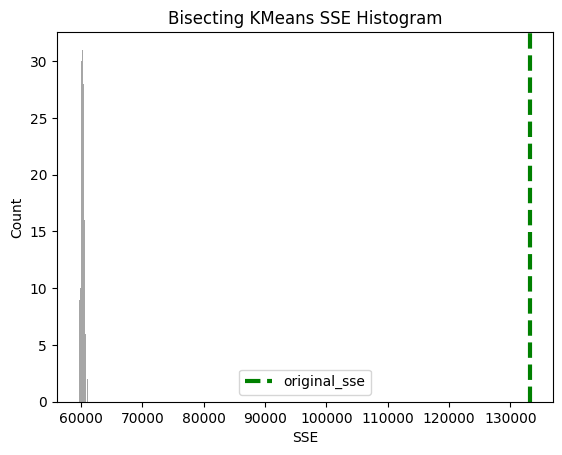

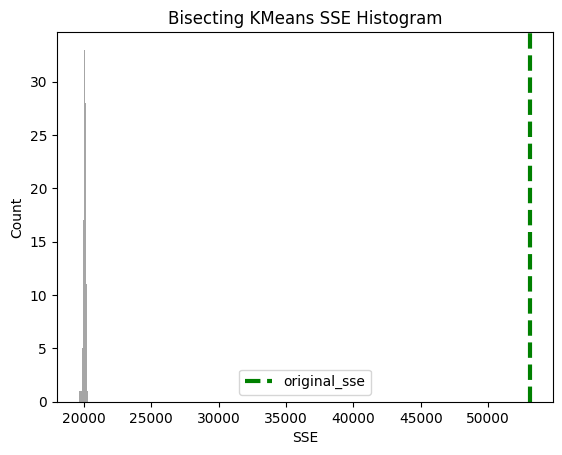

CPU times: user 1min 43s, sys: 17.7 s, total: 2min
Wall time: 1min 32s


In [ ]:
%%time

# Compute the correlations
correlation_bkm = compute_correlation(X, bkmeans.labels_)
correlation_outcut_bkm = compute_correlation(X_outcut, bkmeans_outcut.labels_)

print(f"Correlation for dataset with outliers: {correlation_bkm}")
print(f"Correlation for dataset without outliers: {correlation_outcut_bkm}")

'''def bkmeans_evaluation(df, n_permutations, n_clusters, original_corr):
  # Initialize a list to store the correlations for the randomized datasets
  random_corrs = []

  for _ in range(n_permutations):
     # Randomize the data
     df_random = np.random.permutation(df)

     # Compute the clustering for the randomized data
     bkmeans = BisectingKMeans(n_clusters=n_clusters, n_init=10)
     labels_random = bkmeans.fit_predict(df_random)

     # Compute the correlation for the randomized data
     random_corr = compute_correlation(df_random, labels_random)

     # Store the correlation
     random_corrs.append(random_corr)

  # Convert the list of correlations to a numpy array
  random_corrs = np.array(random_corrs)

  # Compute the p-value
  p_value = np.sum(random_corrs >= original_corr) / n_permutations

  # Plot histogram of correlations
  plt.hist(random_corrs, bins=30, alpha=0.5, color='grey', density=True)
  # Plot the KDE
  sns.kdeplot(random_corrs, color='k', linewidth=2)

  plt.axvline(x=original_corr, color='g', linestyle='dashed', linewidth=3)
  plt.title('Histogram of Correlations')
  plt.xlabel('Correlation')
  plt.ylabel('Frequency')
  plt.text(0.95, 0.95, f'p-value: {p_value:.2f}', horizontalalignment='right',
           verticalalignment='top', transform=plt.gca().transAxes, fontsize=12, fontweight='bold')
  plt.show()

  return p_value'''

N = 200
X_sse = bkmeans.inertia_
X_outcut_sse = bkmeans_outcut.inertia_

def bkmeans_evaluation(df, N, original_sse, n_clusters):
  sse_stats = []

  for _ in range(N):
    Xi = np.zeros(shape=df.shape)

    for cidx in range(Xi.shape[1]):
        col = df.iloc[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    bkmeans = BisectingKMeans(n_clusters=n_clusters, n_init=10, max_iter=100, random_state=73)
    bkmeans.fit(Xi)
    sse_stats.append(bkmeans.inertia_)

  plt.hist(sse_stats, bins='auto', color='grey', alpha=0.7)
  plt.axvline(x=original_sse, color='g', linestyle='dashed', linewidth=3, label = 'original_sse')
  plt.xlabel('SSE')
  plt.ylabel('Count')
  plt.title("Bisecting KMeans SSE Histogram")
  plt.legend()
  plt.show()

bkmeans_evaluation(X, N, X_sse, 3)
bkmeans_evaluation(X_outcut, N, X_outcut_sse, 4)

In [ ]:
X_outcut.columns

Index(['processing', 'genre', 'acousticness', 'energy'], dtype='object')

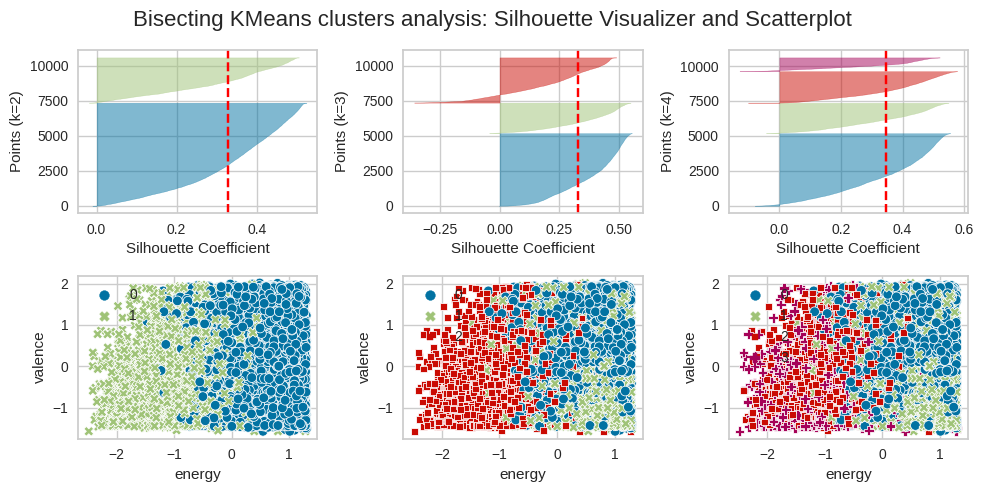

In [ ]:
'''!pip install -q yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

colors=['C0', 'C1', 'C2', 'C3']
n_clust = 5
fig, axs = plt.subplots(n_clust-2, 2, figsize=(10,10))

# Aggiungi un titolo all'intera figura
fig.suptitle('Cluster analysis: Silhouette Visualizer and Scatterplot', fontsize=16)

for i in range(2, n_clust):
    bkmeans_viz = BisectingKMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(bkmeans_viz, colors=colors, ax=axs[i-2][0])

    # Aggiungi etichette agli assi del grafico a silhouette
    axs[i-2][0].set_xlabel("Silhouette Coefficient")
    axs[i-2][0].set_ylabel("Points (k=" + str(i) + ")")

    visualizer.fit(X_outcut)
    sns.scatterplot(data=X_outcut, x="instrumentalness", y="acousticness", hue=bkmeans_viz.labels_,
                    palette=sns.color_palette(colors[:i]), style=bkmeans_viz.labels_, ax=axs[i-2][1])
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Assicurati che il titolo non sovrapponga i subplot'''

!pip install -q yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

colors=['C0', 'C1', 'C2', 'C3']
n_clust = 5
fig, axs = plt.subplots(2, n_clust-2, figsize=(10,5))

# Aggiungi un titolo all'intera figura
fig.suptitle('Bisecting KMeans clusters analysis: Silhouette Visualizer and Scatterplot', fontsize=16)

for i in range(2, n_clust):
    bkmeans_viz = BisectingKMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(bkmeans_viz, colors=colors, ax=axs[0][i-2])

    # Aggiungi etichette agli assi del grafico a silhouette
    axs[0][i-2].set_xlabel("Silhouette Coefficient")
    axs[0][i-2].set_ylabel("Points (k=" + str(i) + ")")

    visualizer.fit(X_outcut)
    sns.scatterplot(data=X_outcut, x=X_outcut[feature_importances_X_outcut[2][0]], y=X_outcut[feature_importances_X_outcut[3][0]], hue=bkmeans_viz.labels_,
                    palette=sns.color_palette(colors[:i]), style=bkmeans_viz.labels_, ax=axs[1][i-2])
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Assicurati che il titolo non sovrapponga i subplot

### X-means

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

In [ ]:
!pip install -q pyclustering
from pyclustering.cluster import xmeans

xm = xmeans.xmeans(X)
xm.process()
x_clusters = xm.get_clusters()

xm_outcut = xmeans.xmeans(X_outcut)
xm_outcut.process()
x_clusters_outcut = xm_outcut.get_clusters()

def clusters_to_labels(clusters):
    labels = np.empty(shape=(len(np.concatenate(clusters))), dtype=int)
    for i in range(len(clusters)):
        for idx in clusters[i]:
            labels[idx] = i
    return labels

labels_xm = clusters_to_labels(x_clusters)
labels_outcut_xm = clusters_to_labels(x_clusters_outcut)

centers_xm = np.array(xm.get_centers())
centers_outcut_xm = np.array(xm_outcut.get_centers())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
'''# Function to calculate SSE
def calculate_sse(X, labels, centroids):
    sse = 0
    for i in range(len(X)):
        # find the centroid that the sample was assigned to
        centroid = centroids[labels[i]]
        # add the squared distance between the sample and the centroid
        sse += np.sum((X[i] - centroid) ** 2)
    return sse

# Function to calculate centroids
def calculate_centroids(X, labels):
    unique_labels = np.unique(labels)
    centroids = []
    for label in unique_labels:
        # find all samples with the current label
        samples = X[labels == label]
        # calculate the centroid of these samples
        centroid = np.mean(samples, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

# Your clustering_metrics function
def clustering_metrics_xm(dataframe, labels):
    # calculate centroids
    centroids = calculate_centroids(dataframe.values, labels)
    # calculate sse
    sse = calculate_sse(dataframe.values, labels, centroids)
    # calculate silhouette score
    dist = squareform(pdist(dataframe))
    sil = silhouette_score(dist, labels, metric='precomputed')
    return sse, sil

# Your loop
for i in range(10, 2, -1):
    X_i = X[[x[0] for x in feature_importances_X[0:i]]]
    X_outcut_i = X_outcut[[x[0] for x in feature_importances_X_outcut[0:i]]]

    print(f"------------- {i} features -------------")
    print(f"SSE X{i}: {clustering_metrics_xm(X_i, labels_xm)[0]:.2f}")
    print(f"SIL X{i}: {clustering_metrics_xm(X_i, labels_outcut_xm)[1]:.2f}")
    print('-----------------------------------------')
    print(f"SSE X_outcut{i}: {clustering_metrics_xm(X_outcut_i, labels_xm)[0]:.2f}")
    print(f"SIL X_outcut{i}: {clustering_metrics_xm(X_outcut_i, labels_outcut_xm)[1]:.2f}")
    print('-----------------------------------------')
'''

------------- 10 features -------------
SSE X10: 63237.15


IndexError: ignored

In [ ]:
'''sns.scatterplot(data=df, x="mean radius", y="mean concave points", hue=labels, palette="bright", style=labels)
plt.scatter(centers_unscaled[:, 0], centers_unscaled[:,7], color="black", marker="*", s=100)'''

## Density-based clustering

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

### eps and minPts

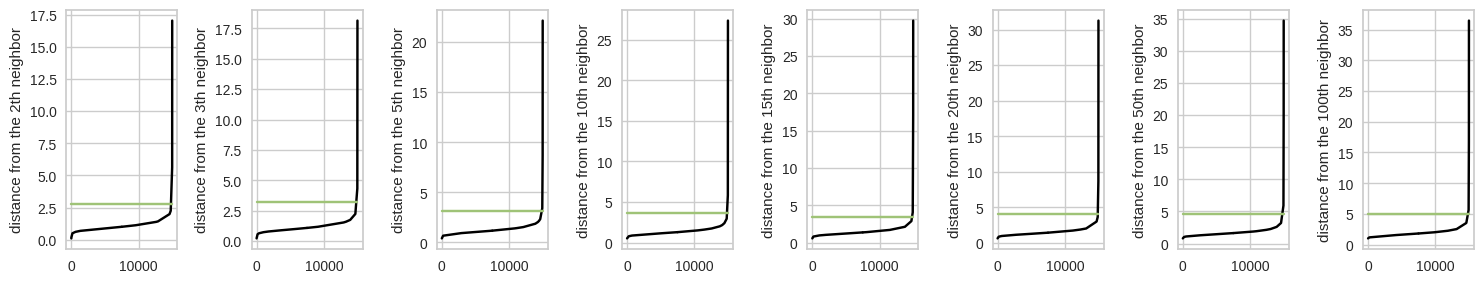

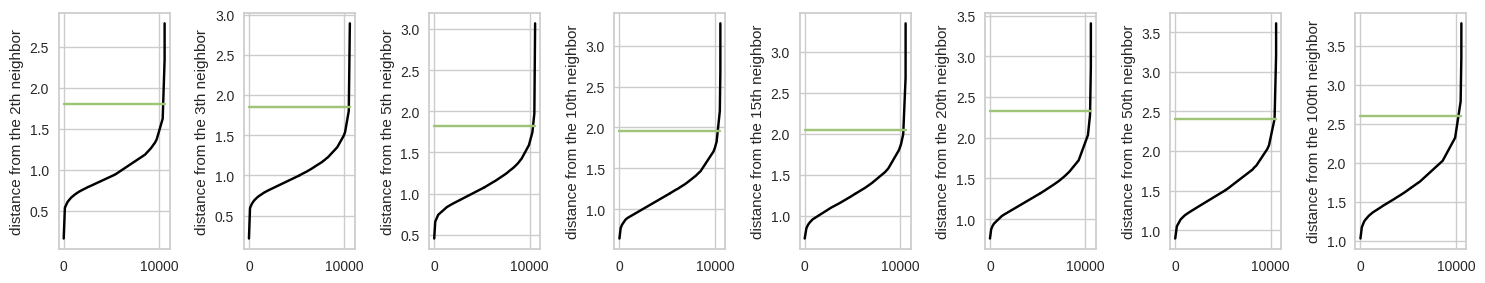

In [ ]:
ks = [2, 3, 5, 10, 15, 20, 50, 100]
X_eps = []
X_outcut_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(X, ks, X_eps)
eps_choice(X_outcut, ks, X_outcut_eps)

In [ ]:
print(ks)
print(X_eps)
print(X_outcut_eps)

[2, 3, 5, 10, 15, 20, 50, 100]
[2.77, 3.23, 3.18, 3.66, 3.41, 4.0, 4.53, 4.98]
[1.8, 1.85, 1.82, 1.96, 2.05, 2.32, 2.41, 2.6]


In [ ]:
dist_X = squareform(pdist(X, 'euclidean'))
dist_X_outcut = squareform(pdist(X_outcut, 'euclidean'))

In [ ]:
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=X, eps=X_eps, ks=ks)

[-1  0  1  2  3  4] [   57 14926     6     4     5     2]
eps=2.77, minPts=2 -> 5 clusters
Cluster [-1]: 57 samples
Cluster [0]: 14926 samples
Cluster [1]: 6 samples
Cluster [2]: 4 samples
Cluster [3]: 5 samples
Cluster [4]: 2 samples
Silhouette (F) 0.43512997836081374
--------------------------------
[-1  0  1  2  3  4] [   34 14950     4     3     5     4]
eps=3.23, minPts=3 -> 5 clusters
Cluster [-1]: 34 samples
Cluster [0]: 14950 samples
Cluster [1]: 4 samples
Cluster [2]: 3 samples
Cluster [3]: 5 samples
Cluster [4]: 4 samples
Silhouette (F) 0.43373413123627036
--------------------------------
[-1  0] [   50 14950]
eps=3.18, minPts=5 -> 1 clusters
Cluster [-1]: 50 samples
Cluster [0]: 14950 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   41 14959]
eps=3.66, minPts=10 -> 1 clusters
Cluster [-1]: 41 samples
Cluster [0]: 14959 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[

In [ ]:
dbscan_results(X_outcut, eps=X_outcut_eps, ks=ks)

[-1  0  1] [   31 10542     2]
eps=1.8, minPts=2 -> 2 clusters
Cluster [-1]: 31 samples
Cluster [0]: 10542 samples
Cluster [1]: 2 samples
Silhouette (F) 0.1885793615930801
--------------------------------
[-1  0] [   33 10542]
eps=1.85, minPts=3 -> 1 clusters
Cluster [-1]: 33 samples
Cluster [0]: 10542 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   38 10537]
eps=1.82, minPts=5 -> 1 clusters
Cluster [-1]: 38 samples
Cluster [0]: 10537 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   42 10533]
eps=1.96, minPts=10 -> 1 clusters
Cluster [-1]: 42 samples
Cluster [0]: 10533 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [   42 10533]
eps=2.05, minPts=15 -> 1 clusters
Cluster [-1]: 42 samples
Cluster [0]: 10533 samples
Cannot calculate silhouette score with only one cluster
--------------------------------
[-1  0] [

#### k, fixed eps

In [ ]:
eps = np.mean(X_eps)
eps_cut = np.mean(X_outcut_eps)

k_range = range(2,51)

In [ ]:
eps_cut

2.10125

In [ ]:
%%time
def dbscan_results_v2(df, eps, ks):
    best_model = None
    best_silhouette = -1
    best_eps = None
    best_min_samples = None

    for i in range(len(ks)):
        db = DBSCAN(eps=eps, min_samples=ks[i]).fit(df)
        labels, counts = np.unique(db.labels_, return_counts=True)

        clustering_labels = db.fit_predict(df)
        df.loc[:, 'db_labels'] = clustering_labels
        if len(np.unique(db.labels_)) > 2:
            silhouette = silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1])
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_model = db
                best_eps = eps
                best_min_samples = ks[i]

    print(f"Miglior modello: eps={best_eps}, minPts={best_min_samples} -> silhouette={best_silhouette}")
    return best_model

best_db_X_full = dbscan_results_v2(df=X, eps=eps, ks=k_range)

Miglior modello: eps=3.72, minPts=2 -> silhouette=0.44766311295495254
CPU times: user 21min 4s, sys: 49.5 s, total: 21min 54s
Wall time: 21min 59s


In [ ]:
%%time
best_db_Xcut_full = dbscan_results_v2(df=X_outcut, eps=eps_cut, ks=k_range)

Miglior modello: eps=None, minPts=None -> silhouette=-1
CPU times: user 8min 41s, sys: 1.02 s, total: 8min 42s
Wall time: 8min 45s


#### selected features

In [ ]:
# Selecting same features of kmeans
kmeans_features_X = ['speechiness', 'acousticness', 'energy']
kmeans_features_X_outcut = ['instrumentalness', 'acousticness', 'energy']

X = X[kmeans_features_X]
X_outcut = X_outcut[kmeans_features_X_outcut]

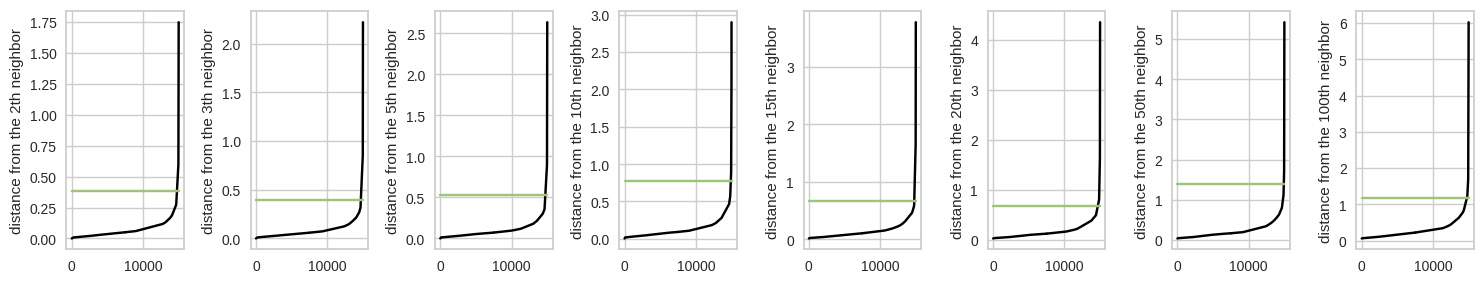

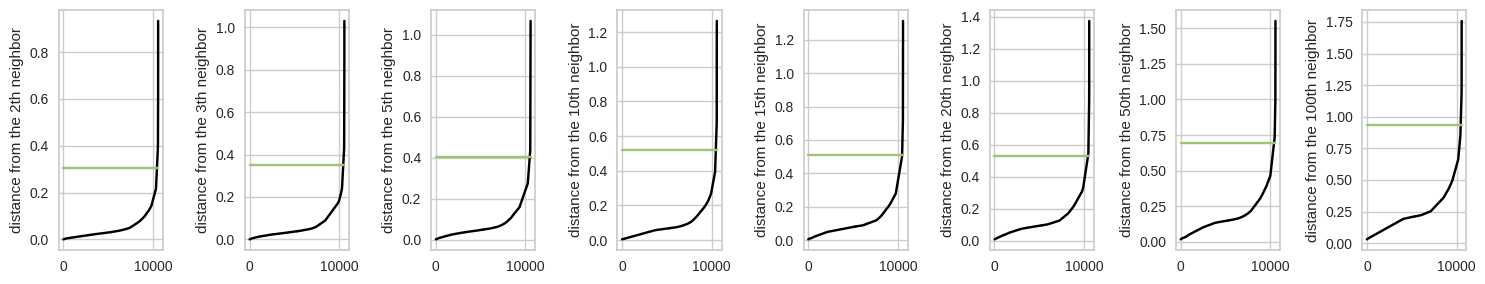

[0.38, 0.39, 0.53, 0.77, 0.66, 0.67, 1.39, 1.18]
[0.3, 0.35, 0.4, 0.52, 0.51, 0.53, 0.69, 0.94]


In [ ]:
X_eps = []
X_outcut_eps = []

eps_choice(X, ks, X_eps)
eps_choice(X_outcut, ks, X_outcut_eps)

print(X_eps)
print(X_outcut_eps)

In [ ]:
best_db_X_selected = dbscan_results(df=X, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26] [   80 14813     3     2    36     8     2     6     3     6     3     2
     2     2     2     2     3     2     2     4     2     2     3     2
     2     2     2     2]
eps=0.38, minPts=2 -> 27 clusters
Cluster [-1]: 80 samples
Cluster [0]: 14813 samples
Cluster [1]: 3 samples
Cluster [2]: 2 samples
Cluster [3]: 36 samples
Cluster [4]: 8 samples
Cluster [5]: 2 samples
Cluster [6]: 6 samples
Cluster [7]: 3 samples
Cluster [8]: 6 samples
Cluster [9]: 3 samples
Cluster [10]: 2 samples
Cluster [11]: 2 samples
Cluster [12]: 2 samples
Cluster [13]: 2 samples
Cluster [14]: 2 samples
Cluster [15]: 3 samples
Cluster [16]: 2 samples
Cluster [17]: 2 samples
Cluster [18]: 4 samples
Cluster [19]: 2 samples
Cluster [20]: 2 samples
Cluster [21]: 3 samples
Cluster [22]: 2 samples
Cluster [23]: 2 samples
Cluster [24]: 2 samples
Cluster [25]: 2 samples
Cluster [26]: 2 samples
Silhouette (F) 0.3789518092167577
-----

In [ ]:
best_db_Xcut_selected = dbscan_results(X_outcut, eps=X_outcut_eps, ks=ks)

[-1  0  1  2  3  4  5  6  7] [   30 10523     6     4     2     4     2     2     2]
eps=0.3, minPts=2 -> 8 clusters
Cluster [-1]: 30 samples
Cluster [0]: 10523 samples
Cluster [1]: 6 samples
Cluster [2]: 4 samples
Cluster [3]: 2 samples
Cluster [4]: 4 samples
Cluster [5]: 2 samples
Cluster [6]: 2 samples
Cluster [7]: 2 samples
Silhouette (F) 0.01819151342994071
--------------------------------
[-1  0  1  2  3] [   38 10523     6     4     4]
eps=0.35, minPts=3 -> 4 clusters
Cluster [-1]: 38 samples
Cluster [0]: 10523 samples
Cluster [1]: 6 samples
Cluster [2]: 4 samples
Cluster [3]: 4 samples
Silhouette (F) -0.006109562272364218
--------------------------------
[-1  0  1] [   47 10522     6]
eps=0.4, minPts=5 -> 2 clusters
Cluster [-1]: 47 samples
Cluster [0]: 10522 samples
Cluster [1]: 6 samples
Silhouette (F) 0.01702833506046271
--------------------------------
[-1  0] [   53 10522]
eps=0.52, minPts=10 -> 1 clusters
Cluster [-1]: 53 samples
Cluster [0]: 10522 samples
Cannot calculat

In [ ]:
eps = np.mean(X_eps)
eps_cut = np.mean(X_outcut_eps)

dbXselected = dbscan_results_v2(df=X, eps=eps, ks=k_range)

Miglior modello: eps=0.7462500000000001, minPts=12 -> silhouette=0.5997342574433613


In [ ]:
dbXcutselected = dbscan_results_v2(df=X_outcut, eps=eps_cut, ks=k_range)

Miglior modello: eps=0.53, minPts=9 -> silhouette=0.05283371286409911


In [ ]:
print(silhouette_score(X[dbXselected.labels_ != -1], dbXselected.labels_[dbXselected.labels_ != -1]))
print(silhouette_score(X_outcut[dbXcutselected.labels_ != -1], dbXcutselected.labels_[dbXcutselected.labels_ != -1]))

0.5996556971043342
0.05096878205146886


### DBSCAN

In [ ]:
X.columns

Index(['speechiness', 'acousticness', 'energy', 'db_labels'], dtype='object')

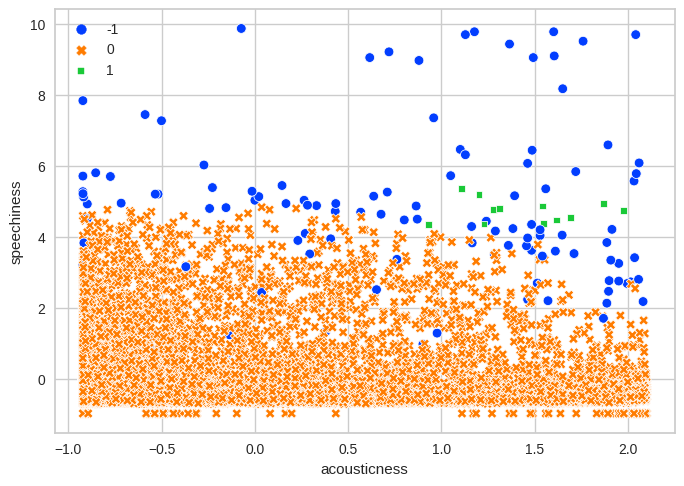

In [ ]:
sns.scatterplot(data=X,
                x="acousticness",
                y="speechiness",
                hue=dbXselected.labels_,
                style=dbXselected.labels_,
                palette="bright")
plt.show()

In [ ]:
silhouette_score(X[dbXselected.labels_ != -1], dbXselected.labels_[dbXselected.labels_ != -1])

0.5996556971043342

### OPTICS

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples = 50, max_eps = np.inf, min_cluster_size=50)
optics.fit(X)

optics_outcut = OPTICS(min_samples = 50, max_eps = np.inf, min_cluster_size=50)
optics_outcut.fit(X_outcut)

if len(np.unique(optics.labels_ )) > 2:
  print("Silhouette F", silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1]))
else:
  print('Cannot calculate silhouette score with only one cluster')

if len(np.unique(optics_outcut.labels_ )) > 2:
  print("Silhouette C", silhouette_score(X_outcut[optics_outcut.labels_ != -1], optics_outcut.labels_[optics_outcut.labels_ != -1]))
else:
  print('Cannot calculate silhouette score with only one cluster')



Cannot calculate silhouette score with only one cluster
Cannot calculate silhouette score with only one cluster


Text(0.5, 1.0, 'Reachability Plot')

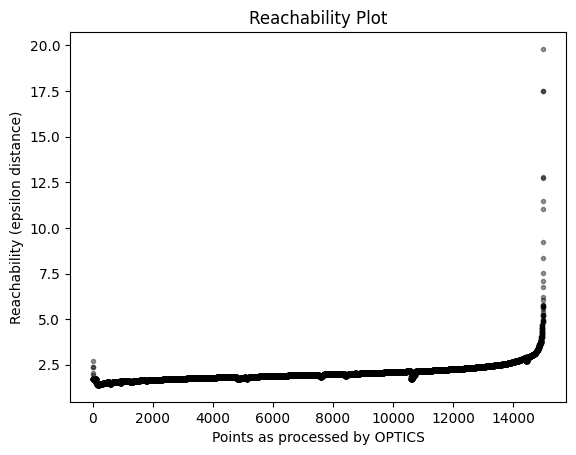

In [ ]:
# Valleys in the plot correspond to the clusters
space = np.arange(len(X))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

# Reachability plot
plt.plot(space, reachability, "k.", alpha=0.4)
plt.xlabel("Points as processed by OPTICS")
plt.ylabel("Reachability (epsilon distance)")
# plt.axhline(0.3, c="red")
plt.title("Reachability Plot")

## Hierarchical clustering

In [ ]:
X = F.copy(deep = True)
X_outcut = C.copy(deep = True)

In [ ]:
def get_linkage_matrix(model):
    # Create linkage matrix

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
dist_X = squareform(pdist(X, 'euclidean'))
dist_X_outcut = squareform(pdist(X_outcut, 'euclidean'))

# Precompute Manhattan distance
dist_X_manhattan = squareform(pdist(X, 'cityblock'))
dist_X_outcut_manhattan = squareform(pdist(X_outcut, 'cityblock'))

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
# it is the linkage distance threshold above which clusters will not be merged

model_X = AgglomerativeClustering(distance_threshold=0, n_clusters=None,
                                metric='precomputed', linkage='average').fit(dist_X)
model_X_outcut = AgglomerativeClustering(distance_threshold=0, n_clusters=None,
                                metric='precomputed', linkage='average').fit(dist_X_outcut)

In [ ]:
plt.title("Hierarchical Clustering Dendrogram F")
plot_dendrogram(model_X, truncate_mode='lastp', color_threshold=0.7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
plt.title("Hierarchical Clustering Dendrogram C")
plot_dendrogram(model_X_outcut, truncate_mode='lastp', color_threshold=0.7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# distances = ['euclidean', 'manhattan']
linkages = ['single', 'complete', 'average', 'ward']

In [ ]:
# EUCLIDEAN

# Inizializza un dizionario per memorizzare i modelli e i loro punteggi
models = {}

for link in linkages:
  if (link == 'ward'):
    model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                          metric='euclidean', linkage=link).fit(X)
    model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                                 metric='euclidean', linkage=link).fit(X_outcut)
  else:
    model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                          metric='precomputed', linkage=link).fit(dist_X)
    model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                                 metric='precomputed', linkage=link).fit(dist_X_outcut)

  # Calcola il punteggio della silhouette per ogni modello
  silhouette_X = silhouette_score(dist_X, model_X.labels_)
  silhouette_X_outcut = silhouette_score(dist_X_outcut, model_X_outcut.labels_)

  # Memorizza i modelli e i loro punteggi
  models[('euclidean', link, 'X')] = (model_X, silhouette_X)
  models[('euclidean', link, 'X_outcut')] = (model_X_outcut, silhouette_X_outcut)

# Stampa i risultati
for key, value in models.items():
    print(f'Distance: {key[0]}, Linkage: {key[1]}, Dataset: {key[2]}, Silhouette Score: {value[1]}')
    print(f'Cluster sizes: {np.bincount(value[0].labels_)}')

# Trova il modello con il punteggio della silhouette più alto
best_hier_euc = max(models.items(), key=lambda x: x[1][1])

print(f'Best model is {best_hier_euc[0]} with silhouette {best_hier_euc[1][1]:.2f}')

Distance: euclidean, Linkage: single, Dataset: X, Silhouette Score: 0.9292402647756356
Cluster sizes: [14997     2     1]
Distance: euclidean, Linkage: single, Dataset: X_outcut, Silhouette Score: 0.2548652482498309
Cluster sizes: [10573     1     1]
Distance: euclidean, Linkage: complete, Dataset: X, Silhouette Score: 0.9295304476846687
Cluster sizes: [14993     5     2]
Distance: euclidean, Linkage: complete, Dataset: X_outcut, Silhouette Score: 0.09777878892448974
Cluster sizes: [2513 5533 2529]
Distance: euclidean, Linkage: average, Dataset: X, Silhouette Score: 0.9296000459185108
Cluster sizes: [    6 14992     2]
Distance: euclidean, Linkage: average, Dataset: X_outcut, Silhouette Score: 0.2280683965907533
Cluster sizes: [1136    1 9438]
Distance: euclidean, Linkage: ward, Dataset: X, Silhouette Score: 0.11771822452168516
Cluster sizes: [5874 1347 7779]
Distance: euclidean, Linkage: ward, Dataset: X_outcut, Silhouette Score: 0.14768564106161308
Cluster sizes: [3870 4642 2063]
Bes

In [ ]:
'''from collections import Counter

best_model = best_hier_euc[1][0]
labels = best_model.fit_predict(dist_X)
counter = Counter(labels)
counter'''

Counter({1: 14993, 0: 4, 2: 1, 3: 2})

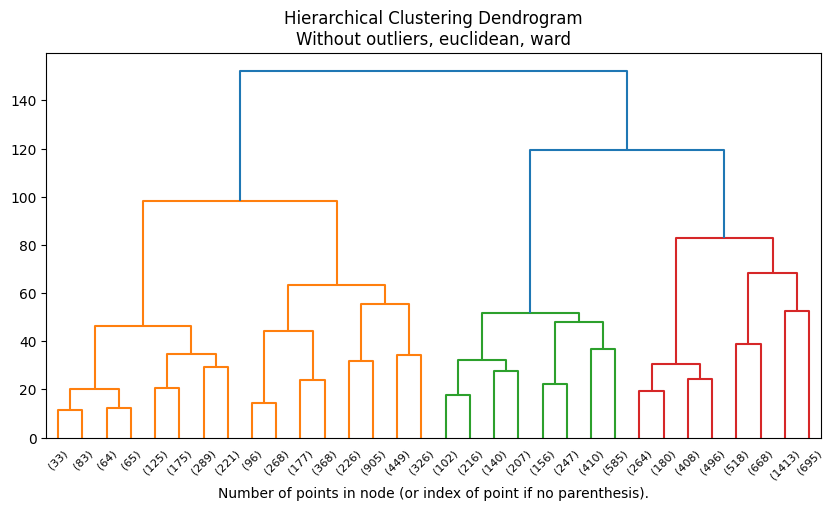

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute the linkage matrix
Z = linkage(pdist(X_outcut, 'euclidean'), 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram\nWithout outliers, euclidean, ward')
dendrogram(Z, truncate_mode='level', p=4, color_threshold=100)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
%%time
# MANHATTAN

linkages_man = ['single', 'complete', 'average']

# Inizializza un dizionario per memorizzare i modelli e i loro punteggi
models_man = {}

for link in linkages_man:
  # Crea e adatta il modello sui due set di dati
  model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                          metric='precomputed', linkage=link).fit(dist_X_manhattan)
  model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=3,
                                                 metric='precomputed', linkage=link).fit(dist_X_outcut_manhattan)

  # Calcola il punteggio della silhouette per ogni modello
  silhouette_X = silhouette_score(dist_X_manhattan, model_X.labels_)
  silhouette_X_outcut = silhouette_score(dist_X_outcut_manhattan, model_X_outcut.labels_)

  # Memorizza i modelli e i loro punteggi
  models_man[('manhattan', link, 'X')] = (model_X, silhouette_X)
  models_man[('manhattan', link, 'X_outcut')] = (model_X_outcut, silhouette_X_outcut)

# Stampa i risultati
for key, value in models_man.items():
    print(f'Distance: {key[0]}, Linkage: {key[1]}, Dataset: {key[2]}, Silhouette Score: {value}')

# Trova il modello con il punteggio della silhouette più alto
best_hier_man = max(models_man.items(), key=lambda x: x[1][1])

print(f'Best model is {best_hier_man[0]} with silhouette {best_hier_man[1][1]:.2f}')


In [ ]:
best_model_man = best_hier_man[1][0]
labels_man = best_model_man.fit_predict(dist_X)
counter_man = Counter(labels_man)
print(counter_man)

# Compute the linkage matrix
Z_man = linkage(pdist(X, 'euclidean'), 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram\nFull Dataset, manhattan, single')
dendrogram(Z, truncate_mode='level', p=4, color_threshold=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#### Test ward

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
# it is the linkage distance threshold above which clusters will not be merged
# Recupera il modello
model_ward_cut = models[('euclidean', 'ward', 'X_outcut')][0]
model_ward = models[('euclidean', 'ward', 'X')][0]

# Ora puoi utilizzare 'model' per visualizzare le caratteristiche del tuo modello
# Ad esempio, per visualizzare le etichette dei cluster
print(model_ward_cut.labels_)

[2 2 0 ... 2 1 0]


In [ ]:
from scipy.cluster.hierarchy import linkage

Z_ward_cut = linkage(dist_X_outcut, method='ward')

labels_ward_cut = fcluster(Z_ward_cut, t=0.7, criterion='distance')

<ipython-input-32-6532105c056a>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_ward_cut = linkage(dist_X_outcut, method='ward')


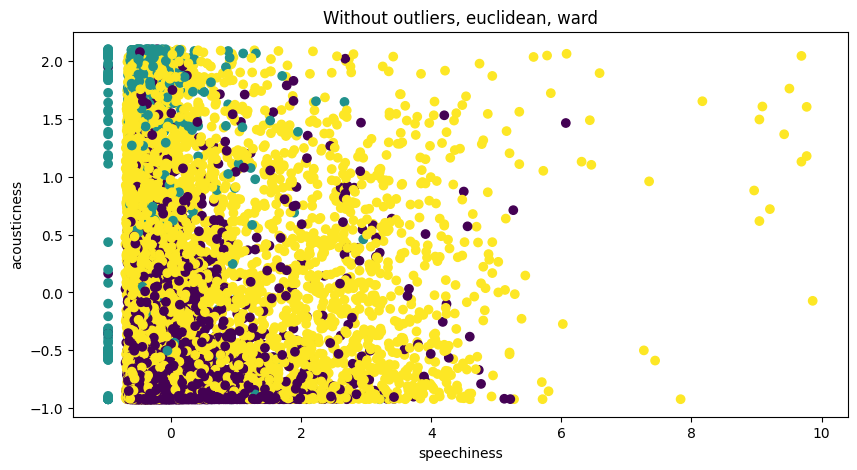

In [ ]:
# Crea uno scatterplot con i punti colorati in base al loro cluster
plt.figure(figsize=(10, 5))
plt.scatter(X["speechiness"], X["acousticness"], c=model_ward.labels_)
plt.title('Without outliers, euclidean, ward')
plt.xlabel("speechiness")
plt.ylabel("acousticness")
plt.show()

In [ ]:
print('Silhouette', silhouette_score(dist_X_outcut, labels_ward_cut))

Silhouette 0.0007509702222244388


In [ ]:
N = 100
sse_stats = []
for _ in range(N):
    Xi = np.zeros(shape=X.shape)

    for cidx in range(Xi.shape[1]):
        col = X.iloc[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    D = pairwise_distances(Xi)
    Z = linkage(D, method='ward')
    labels = fcluster(Z, t=3, criterion='maxclust')
    centroids = np.array([Xi[labels == i].mean(axis=0) for i in range(1, max(labels) + 1)])
    sse_stats.append(sum([np.sum((Xi[labels == i] - centroids[i-1])**2) for i in range(1, max(labels) + 1)]))

# Crea l'istogramma
plt.hist(sse_stats, bins='auto')
plt.vlines(x = sse, ymin = 0, ymax = max(sse_stats), colors = 'green', label = 'original_sse')
plt.xlabel('SSE')
plt.ylabel('Count')
plt.legend()
plt.show()

<ipython-input-21-e0253935359b>:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='ward')


KeyboardInterrupt: ignored

#### Selected features

In [ ]:
kmeans_features_X = ['speechiness', 'acousticness', 'energy']
kmeans_features_X_outcut = ['instrumentalness', 'acousticness', 'energy']

X = X[kmeans_features_X]
X_outcut = X_outcut[kmeans_features_X_outcut]

In [ ]:
dist_X = squareform(pdist(X, 'euclidean'))
dist_X_outcut = squareform(pdist(X_outcut, 'euclidean'))

# Precompute Manhattan distance
dist_X_manhattan = squareform(pdist(X, 'cityblock'))
dist_X_outcut_manhattan = squareform(pdist(X_outcut, 'cityblock'))

In [ ]:
# EUCLIDEAN

# Inizializza un dizionario per memorizzare i modelli e i loro punteggi
models_selected = {}

for link in linkages:
  if (link == 'ward'):
    model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                          metric='euclidean', linkage=link).fit(X)
    model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                                 metric='euclidean', linkage=link).fit(X_outcut)
  else:
    model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                          metric='precomputed', linkage=link).fit(dist_X)
    model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                                 metric='precomputed', linkage=link).fit(dist_X_outcut)

  # Calcola il punteggio della silhouette per ogni modello
  silhouette_X = silhouette_score(dist_X, model_X.labels_)
  silhouette_X_outcut = silhouette_score(dist_X_outcut, model_X_outcut.labels_)

  # Memorizza i modelli e i loro punteggi
  models_selected[('euclidean', link, 'X')] = (model_X, silhouette_X)
  models_selected[('euclidean', link, 'X_outcut')] = (model_X_outcut, silhouette_X_outcut)

# Stampa i risultati
for key, value in models_selected.items():
    print(f'Distance: {key[0]}, Linkage: {key[1]}, Dataset: {key[2]}, Silhouette Score: {value}')

# Trova il modello con il punteggio della silhouette più alto
best_hier_euc_selected = max(models_selected.items(), key=lambda x: x[1][1])

print(f'Best model is {best_hier_euc_selected[0]} with silhouette {best_hier_euc_selected[1][1]:.2f}')

Distance: euclidean, Linkage: single, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=4), 0.7653950849294912)
Distance: euclidean, Linkage: single, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=4), -0.11943481984751879)
Distance: euclidean, Linkage: complete, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='complete', metric='precomputed', n_clusters=4), 0.2959751674221945)
Distance: euclidean, Linkage: complete, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='complete', metric='precomputed', n_clusters=4), 0.20496016398694528)
Distance: euclidean, Linkage: average, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='average', metric='precomputed', n_clusters=4), 0.48683178743724675)
Distance: euclidean, Linkage: average, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='average', metric='prec

In [ ]:
from collections import Counter

best_model_selected = best_hier_euc_selected[1][0]
labels_selected = best_model_selected.fit_predict(dist_X)
Counter(labels_selected)

Counter({2: 14984, 0: 13, 1: 2, 3: 1})

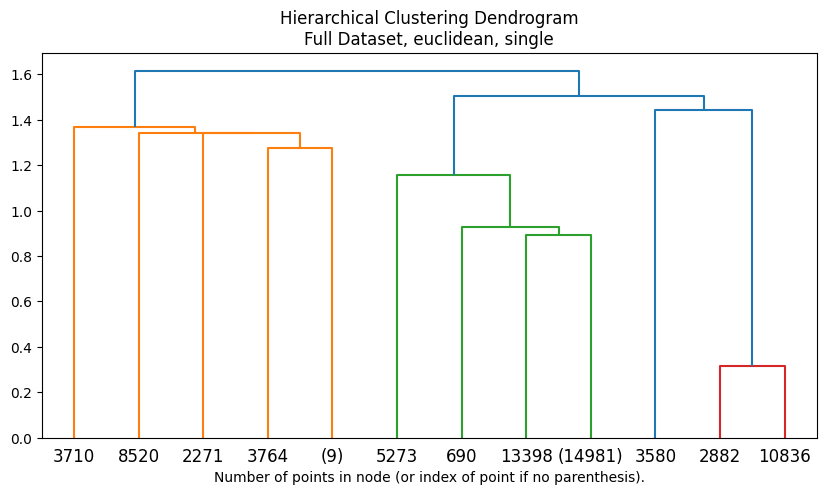

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute the linkage matrix
Z = linkage(pdist(X, 'euclidean'), 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram\nFull Dataset, euclidean, single')
dendrogram(Z, truncate_mode='level', p=4, color_threshold=1.4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
%%time
# MANHATTAN

# Inizializza un dizionario per memorizzare i modelli e i loro punteggi
models_man_selected = {}

for link in linkages_man:
  # Crea e adatta il modello sui due set di dati
  model_X = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                          metric='precomputed', linkage=link).fit(dist_X_manhattan)
  model_X_outcut = AgglomerativeClustering(distance_threshold=None, n_clusters=4,
                                                 metric='precomputed', linkage=link).fit(dist_X_outcut_manhattan)

  # Calcola il punteggio della silhouette per ogni modello
  silhouette_X = silhouette_score(dist_X_manhattan, model_X.labels_)
  silhouette_X_outcut = silhouette_score(dist_X_outcut_manhattan, model_X_outcut.labels_)

  # Memorizza i modelli e i loro punteggi
  models_man_selected[('manhattan', link, 'X')] = (model_X, silhouette_X)
  models_man_selected[('manhattan', link, 'X_outcut')] = (model_X_outcut, silhouette_X_outcut)

# Stampa i risultati
for key, value in models_man_selected.items():
    print(f'Distance: {key[0]}, Linkage: {key[1]}, Dataset: {key[2]}, Silhouette Score: {value}')

# Trova il modello con il punteggio della silhouette più alto
best_hier_man_selected = max(models_man_selected.items(), key=lambda x: x[1][1])

print(f'Best model is {best_hier_man_selected[0]} with silhouette {best_hier_man_selected[1][1]:.2f}')


Distance: manhattan, Linkage: single, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=4), 0.7551879111362821)
Distance: manhattan, Linkage: single, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='single', metric='precomputed', n_clusters=4), -0.02046970150087763)
Distance: manhattan, Linkage: complete, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='complete', metric='precomputed', n_clusters=4), 0.3992584070336004)
Distance: manhattan, Linkage: complete, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='complete', metric='precomputed', n_clusters=4), 0.3344126392931363)
Distance: manhattan, Linkage: average, Dataset: X, Silhouette Score: (AgglomerativeClustering(linkage='average', metric='precomputed', n_clusters=4), 0.38237078000799846)
Distance: manhattan, Linkage: average, Dataset: X_outcut, Silhouette Score: (AgglomerativeClustering(linkage='average', metric='preco

Counter({2: 14984, 0: 13, 1: 2, 3: 1})


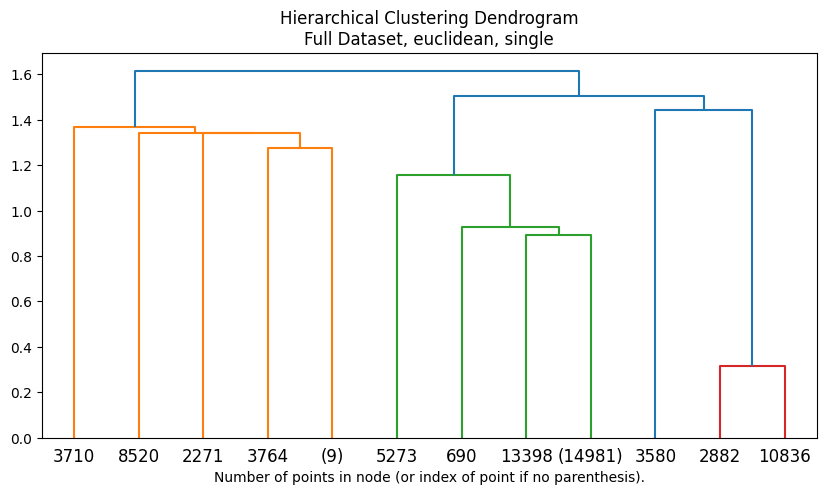

In [ ]:
best_model_man = best_hier_man_selected[1][0]
labels_man = best_model_man.fit_predict(dist_X)
counter_man = Counter(labels_man)
print(counter_man)

# Compute the linkage matrix
Z_man = linkage(pdist(X, 'euclidean'), 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram\nFull Dataset, euclidean, single')
dendrogram(Z_man, truncate_mode='level', p=4, color_threshold=1.4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()